In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import category_encoders as ce
import os
import pickle
import gc
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit

Using TensorFlow backend.


In [14]:
def encode_text_features(encode_decode, data_frame, encoder_isa=None, encoder_mem_type=None):
    # Implement Categorical OneHot encoding for ISA and mem-type
    if encode_decode == 'encode':
        encoder_isa = ce.one_hot.OneHotEncoder(cols=['isa'])
        encoder_mem_type = ce.one_hot.OneHotEncoder(cols=['mem-type'])
        encoder_isa.fit(data_frame, verbose=1)
        df_new1 = encoder_isa.transform(data_frame)
        encoder_mem_type.fit(df_new1, verbose=1)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
    else:
        df_new1 = encoder_isa.transform(data_frame)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
        
    return encoded_data_frame, encoder_isa, encoder_mem_type

In [15]:
all_datasets = 'C:\\Users\\Rajat\\Desktop\\PROJECT_MODE\\Paper_3_Rajat\\Transfer_Learning\\'
dfn = pd.read_csv('qsort_intel_xeon.csv')
df = pd.read_csv('qsort_intel.csv')

In [16]:
df.head()

ps  num-cpus     runtime      power                          arch  \
0  10000         1   1417.9634  27.625819  InteCorei78700_DDR42666_16GB   
1  10000        10   3433.4365  75.175848  InteCorei78700_DDR42666_16GB   
2  10000        11   5709.7232  70.396933  InteCorei78700_DDR42666_16GB   
3  10000        12  13794.7644  66.084130  InteCorei78700_DDR42666_16GB   
4  10000         2   2017.1813  22.357435  InteCorei78700_DDR42666_16GB   

   cpu-clock     isa  l1d_assoc  l1d_cache_lines  l1d_shared_by_threads  ...  \
0      3.168  X86_64          8               64                      1  ...   
1      3.168  X86_64          8               64                      1  ...   
2      3.168  X86_64          8               64                      1  ...   
3      3.168  X86_64          8               64                      1  ...   
4      3.168  X86_64          8               64                      1  ...   

   l2_size  l3_assoc  l3_cache_lines  l3_shared_by_threads  l3_size  mem-size  \
0      256        16              64                     6    12288        16   
1      256        16              64                     6    12288        16   
2      256        16              64                     6    12288        16   
3      256        16              64                     6    12288        16   
4      256        16              64                     6    12288        16   

   mem-type  mem_clock  num-cpu  bus_speed  
0      DDR4       2666        6       4096  
1      DDR4       2666        6       4096  
2      DDR4       2666        6       4096  
3      DDR4       2666        6       4096  
4      DDR4       2666        6       4096  

[5 rows x 24 columns]

In [17]:
dfn.head()

ps  num-cpus    runtime      power                           arch  \
0  10000         1  2913.9938  42.718416  IntelXeonE52620_DDR41866_16GB   
1  10000        10  4150.9162  75.426456  IntelXeonE52620_DDR41866_16GB   
2  10000        11  4796.9393  73.851278  IntelXeonE52620_DDR41866_16GB   
3  10000        12  3869.0799  95.208631  IntelXeonE52620_DDR41866_16GB   
4  10000        13  4409.5984  89.580765  IntelXeonE52620_DDR41866_16GB   

   cpu-clock     isa  l1d_assoc  l1d_cache_lines  l1d_shared_by_threads  ...  \
0        2.4  X86_64          8               64                      1  ...   
1        2.4  X86_64          8               64                      1  ...   
2        2.4  X86_64          8               64                      1  ...   
3        2.4  X86_64          8               64                      1  ...   
4        2.4  X86_64          8               64                      1  ...   

   l2_size  l3_assoc  l3_cache_lines  l3_shared_by_threads  l3_size  mem-size  \
0      256         8              64                    12    15360        16   
1      256         8              64                    12    15360        16   
2      256         8              64                    12    15360        16   
3      256         8              64                    12    15360        16   
4      256         8              64                    12    15360        16   

   mem-type  mem_clock  num-cpu  bus_speed  
0      DDR4       1866       12      32768  
1      DDR4       1866       12      32768  
2      DDR4       1866       12      32768  
3      DDR4       1866       12      32768  
4      DDR4       1866       12      32768  

[5 rows x 24 columns]

In [18]:
df.columns, len(df.columns), dfn.columns, len(dfn.columns) # bus-speed is extra in physical

(Index(['ps', 'num-cpus', 'runtime', 'power', 'arch', 'cpu-clock', 'isa',
        'l1d_assoc', 'l1d_cache_lines', 'l1d_shared_by_threads', 'l1d_size',
        'l2_assoc', 'l2_cache_lines', 'l2_shared_by_threads', 'l2_size',
        'l3_assoc', 'l3_cache_lines', 'l3_shared_by_threads', 'l3_size',
        'mem-size', 'mem-type', 'mem_clock', 'num-cpu', 'bus_speed'],
       dtype='object'),
 24,
 Index(['ps', 'num-cpus', 'runtime', 'power', 'arch', 'cpu-clock', 'isa',
        'l1d_assoc', 'l1d_cache_lines', 'l1d_shared_by_threads', 'l1d_size',
        'l2_assoc', 'l2_cache_lines', 'l2_shared_by_threads', 'l2_size',
        'l3_assoc', 'l3_cache_lines', 'l3_shared_by_threads', 'l3_size',
        'mem-size', 'mem-type', 'mem_clock', 'num-cpu', 'bus_speed'],
       dtype='object'),
 24)

In [19]:
len(df),len(dfn)

(360, 312)

In [20]:
encoded_data_frame, encoder_isa, encoder_mem_type = encode_text_features('encode', df, encoder_isa = None, encoder_mem_type=None)

In [21]:
encoded_data_frame_n, encoder_isa_n, encoder_mem_type_n = encode_text_features('encode', dfn, encoder_isa = None, encoder_mem_type=None)

In [22]:
encoded_data_frame.head()

ps  num-cpus     runtime      power                          arch  \
0  10000         1   1417.9634  27.625819  InteCorei78700_DDR42666_16GB   
1  10000        10   3433.4365  75.175848  InteCorei78700_DDR42666_16GB   
2  10000        11   5709.7232  70.396933  InteCorei78700_DDR42666_16GB   
3  10000        12  13794.7644  66.084130  InteCorei78700_DDR42666_16GB   
4  10000         2   2017.1813  22.357435  InteCorei78700_DDR42666_16GB   

   cpu-clock  isa_1  l1d_assoc  l1d_cache_lines  l1d_shared_by_threads  ...  \
0      3.168      1          8               64                      1  ...   
1      3.168      1          8               64                      1  ...   
2      3.168      1          8               64                      1  ...   
3      3.168      1          8               64                      1  ...   
4      3.168      1          8               64                      1  ...   

   l3_assoc  l3_cache_lines  l3_shared_by_threads  l3_size  mem-size  \
0        16              64                     6    12288        16   
1        16              64                     6    12288        16   
2        16              64                     6    12288        16   
3        16              64                     6    12288        16   
4        16              64                     6    12288        16   

   mem-type_1  mem-type_2  mem_clock  num-cpu  bus_speed  
0           1           0       2666        6       4096  
1           1           0       2666        6       4096  
2           1           0       2666        6       4096  
3           1           0       2666        6       4096  
4           1           0       2666        6       4096  

[5 rows x 25 columns]

In [23]:
encoded_data_frame_n.head()

ps  num-cpus    runtime      power                           arch  \
0  10000         1  2913.9938  42.718416  IntelXeonE52620_DDR41866_16GB   
1  10000        10  4150.9162  75.426456  IntelXeonE52620_DDR41866_16GB   
2  10000        11  4796.9393  73.851278  IntelXeonE52620_DDR41866_16GB   
3  10000        12  3869.0799  95.208631  IntelXeonE52620_DDR41866_16GB   
4  10000        13  4409.5984  89.580765  IntelXeonE52620_DDR41866_16GB   

   cpu-clock  isa_1  l1d_assoc  l1d_cache_lines  l1d_shared_by_threads  ...  \
0        2.4      1          8               64                      1  ...   
1        2.4      1          8               64                      1  ...   
2        2.4      1          8               64                      1  ...   
3        2.4      1          8               64                      1  ...   
4        2.4      1          8               64                      1  ...   

   l2_size  l3_assoc  l3_cache_lines  l3_shared_by_threads  l3_size  mem-size  \
0      256         8              64                    12    15360        16   
1      256         8              64                    12    15360        16   
2      256         8              64                    12    15360        16   
3      256         8              64                    12    15360        16   
4      256         8              64                    12    15360        16   

   mem-type_1  mem_clock  num-cpu  bus_speed  
0           1       1866       12      32768  
1           1       1866       12      32768  
2           1       1866       12      32768  
3           1       1866       12      32768  
4           1       1866       12      32768  

[5 rows x 24 columns]

In [24]:
encoded_data_frame.columns, len(encoded_data_frame.columns)

(Index(['ps', 'num-cpus', 'runtime', 'power', 'arch', 'cpu-clock', 'isa_1',
        'l1d_assoc', 'l1d_cache_lines', 'l1d_shared_by_threads', 'l1d_size',
        'l2_assoc', 'l2_cache_lines', 'l2_shared_by_threads', 'l2_size',
        'l3_assoc', 'l3_cache_lines', 'l3_shared_by_threads', 'l3_size',
        'mem-size', 'mem-type_1', 'mem-type_2', 'mem_clock', 'num-cpu',
        'bus_speed'],
       dtype='object'), 25)

In [25]:
encoded_data_frame_n.columns, len(encoded_data_frame_n.columns)

(Index(['ps', 'num-cpus', 'runtime', 'power', 'arch', 'cpu-clock', 'isa_1',
        'l1d_assoc', 'l1d_cache_lines', 'l1d_shared_by_threads', 'l1d_size',
        'l2_assoc', 'l2_cache_lines', 'l2_shared_by_threads', 'l2_size',
        'l3_assoc', 'l3_cache_lines', 'l3_shared_by_threads', 'l3_size',
        'mem-size', 'mem-type_1', 'mem_clock', 'num-cpu', 'bus_speed'],
       dtype='object'), 24)

In [27]:
total_data_n = encoded_data_frame_n.drop(columns = ['arch','mem-type_1' ])

In [28]:
total_data = encoded_data_frame.drop(columns = ['arch','mem-type_1' ,'mem-type_2' ])

In [29]:
total_data.columns, total_data_n.columns

(Index(['ps', 'num-cpus', 'runtime', 'power', 'cpu-clock', 'isa_1', 'l1d_assoc',
        'l1d_cache_lines', 'l1d_shared_by_threads', 'l1d_size', 'l2_assoc',
        'l2_cache_lines', 'l2_shared_by_threads', 'l2_size', 'l3_assoc',
        'l3_cache_lines', 'l3_shared_by_threads', 'l3_size', 'mem-size',
        'mem_clock', 'num-cpu', 'bus_speed'],
       dtype='object'),
 Index(['ps', 'num-cpus', 'runtime', 'power', 'cpu-clock', 'isa_1', 'l1d_assoc',
        'l1d_cache_lines', 'l1d_shared_by_threads', 'l1d_size', 'l2_assoc',
        'l2_cache_lines', 'l2_shared_by_threads', 'l2_size', 'l3_assoc',
        'l3_cache_lines', 'l3_shared_by_threads', 'l3_size', 'mem-size',
        'mem_clock', 'num-cpu', 'bus_speed'],
       dtype='object'))

In [30]:
total_data = total_data.fillna(0)
total_data_n = total_data_n.fillna(0)

In [31]:
X_Intel = total_data.drop(columns = ['runtime', 'power']).to_numpy()
Y_Intel = total_data[['runtime', 'power']].to_numpy()

In [32]:
X_ARM = total_data_n.drop(columns = ['runtime', 'power']).to_numpy()
Y_ARM = total_data_n[['runtime','power']].to_numpy()

# Train -> Intel Data 
# Test -> Xeon data

In [33]:
X_Intel.shape, X_ARM.shape, Y_Intel.shape, Y_ARM.shape

((360, 20), (312, 20), (360, 2), (312, 2))

In [34]:
Y_Intel[:10], Y_ARM[:10] 

(array([[ 1417.9634    ,    27.62581883],
        [ 3433.4365    ,    75.17584787],
        [ 5709.7232    ,    70.39693273],
        [13794.7644    ,    66.08412972],
        [ 2017.1813    ,    22.3574351 ],
        [ 1896.5153    ,    25.77205678],
        [ 1931.29      ,    45.17695426],
        [ 2020.7552    ,    55.98035823],
        [ 2603.2647    ,    45.23815807],
        [ 2236.9698    ,    64.23113088]]),
 array([[2913.9938    ,   42.71841622],
        [4150.9162    ,   75.42645645],
        [4796.9393    ,   73.85127846],
        [3869.0799    ,   95.20863087],
        [4409.5984    ,   89.58076545],
        [6017.1787    ,   76.78794715],
        [6428.0685    ,   74.74070944],
        [5838.2504    ,   79.88776912],
        [5665.6326    ,   83.60695679],
        [6413.8787    ,   79.52066509]]))

 # Appending 10% data of Xeon in Intel Data (X_train and Y_train)

In [35]:
# Separating ARM data to 1% and 99%
X_train_ARM, X_test_ARM, Y_train_ARM, Y_test_ARM = train_test_split(X_ARM, Y_ARM, test_size = 0.90, random_state=42)
print(X_train_ARM.shape, X_test_ARM.shape, Y_train_ARM.shape, Y_test_ARM.shape)
X_train_Intel = np.append(X_Intel, X_train_ARM,axis = 0)
Y_train_Intel = np.append(Y_Intel, Y_train_ARM,axis = 0)
print(X_train_Intel.shape, Y_train_Intel.shape, X_test_ARM.shape, Y_test_ARM.shape)

(31, 20) (281, 20) (31, 2) (281, 2)
(391, 20) (391, 2) (281, 20) (281, 2)


In [36]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_Intel = scaler_x.fit_transform(X_train_Intel)
X_test_ARM = scaler_x.fit_transform(X_test_ARM)
# Y_train_Intel = np.reshape(Y_train_Intel, (len(Y_train_Intel),1))
# Y_test_ARM = np.reshape(Y_test_ARM, (len(Y_test_ARM),1))
Y_train_Intel = scaler_y.fit_transform(Y_train_Intel)
Y_test_ARM = scaler_y.fit_transform(Y_test_ARM)

In [37]:
X_train = X_train_Intel
X_test = X_test_ARM
Y_train = Y_train_Intel
Y_test = Y_test_ARM
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((391, 20), (281, 20), (391, 2), (281, 2))

In [38]:
Y_test[:5,0], Y_test[:5,1]

(array([ 2.26289281, -0.20010301,  0.22110738,  0.2165746 , -1.06431762]),
 array([ 1.49894553,  0.39194908,  0.67556138,  0.71565648, -1.28642242]))

In [39]:
def absolute_percentage_error(Y_test, Y_pred):
    error = 0
    for i in range(len(Y_test)):
        if(Y_test[i]!= 0 ):
            error = error + (abs(Y_test[i] - Y_pred[i]))/Y_test[i]
        
    error = error/ len(Y_test)
    return error

# 2. Linear Regression + Grid Search

In [40]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
# defining parameter range 
param_grid = {'fit_intercept': [True, False],  
             'normalize' : [True, False], 
             } 
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] fit_intercept=True, normalize=True ..............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] .. fit_intercept=True, normalize=True, score=0.425, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] fit_intercept=True, normalize=True ..............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=True, normalize=True, score=-774756305666521285263360.000, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] fit_intercept=True, normalize=True ..............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=True, normalize=True, score=-1748791449220447731712.000, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . fit_intercept=True, normalize=False, score=0.427, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=True, normalize=False, score=-385633138619309120028672.000, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=True, normalize=False, score=-1757857724307580125184.000, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . fit_intercept=False, normalize=True, score=0.430, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . fit_intercept=False, normalize=True, score=0.829, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . fit_intercept=False, normalize=True, score=0.544, total=   0.0s
[CV] fit_intercept=False, normalize=False ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=False, score=0.430, total=   0.0s
[CV] fit_intercept=False, normalize=False ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=False, score=0.829, total=   0.0s
[CV] fit_intercept=False, normalize=False ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  fit_intercept=False, normalize=False, score=0.544, total=   0.0s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'fit_intercept': False, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)


# Transfer Learning

MSE: 
 3.552255403148211e+23

R2: 
 -2.7168222576784938e+17

MAPE:Runtime 
 234112185.0730816

MAPE:Power 
 180939784.11256292


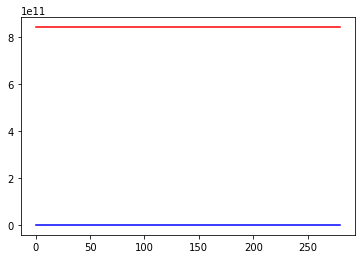

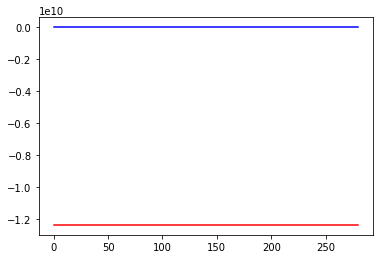

In [41]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.svm import SVR
best_lr = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
best_lr.fit(X_train, Y_train)
Y_pred = best_lr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)

plt.figure()
plt.plot(Y_fold[:,0], 'b')
plt.plot(Y_pred[:,0], 'r')
plt.figure()
plt.plot(Y_fold[:,1], 'b')
plt.plot(Y_pred[:,1], 'r')

r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores_runtime = (absolute_percentage_error(Y_fold[:,0], Y_pred[:,0]))
mape_scores_power = (absolute_percentage_error(Y_fold[:,1], Y_pred[:,1]))

print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE:Runtime \n', mape_scores_runtime)
print('\nMAPE:Power \n', mape_scores_power)


In [42]:
X_train.shape, Y_train.shape

((391, 20), (391, 2))

In [43]:
Y_train[:10], Y_test[:10] 

(array([[-0.77667224, -0.35460417],
        [-0.29081015,  1.53738611],
        [ 0.25792524,  1.34723563],
        [ 2.20695401,  1.1756315 ],
        [-0.63222116, -0.56423035],
        [-0.66130964, -0.42836437],
        [-0.65292664,  0.34374614],
        [-0.63135962,  0.77360782],
        [-0.49093637,  0.34618141],
        [-0.57923762,  1.10190166]]), array([[ 2.26289281,  1.49894553],
        [-0.20010301,  0.39194908],
        [ 0.22110738,  0.67556138],
        [ 0.2165746 ,  0.71565648],
        [-1.06431762, -1.28642242],
        [ 0.5396119 ,  0.54777678],
        [-0.12504572,  0.31619349],
        [-1.07434523, -1.0283469 ],
        [-0.94325734, -0.76748545],
        [-1.1127849 , -1.48614758]]))

In [44]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=1.0, fit_intercept=True, 
                         normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
# defining parameter range 
param_grid = {'alpha': [0.1, 1, 10, 100, 1000],  
             'fit_intercept' : [True, False],
              'normalize' :[True, False],
              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
             } 
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=0.403, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=0.737, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=-0.723, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=0.403, total=   0.1s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=0.737, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=-0.723, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky, score=0.403, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky, score=0.737, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky, score=-0.723, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr, score=0.403, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr, score=0.737, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=lsqr, score=-0.691, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.403, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.737, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.691, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sag, score=0.403, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sag, score=0.737, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=sag, score=-0.703, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=saga, score=0.403, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=saga, score=0.737, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=saga, score=-0.717, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=auto, score=0.429, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=auto, score=0.720, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=auto, score=0.691, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=svd, score=0.429, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=svd, score=0.720, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=svd, score=0.691, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky, score=0.429, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky, score=0.720, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=cholesky, score=0.691, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr, score=0.429, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr, score=0.720, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=lsqr, score=0.691, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.429, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.720, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.691, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sag, score=0.429, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sag, score=0.721, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=sag, score=0.692, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=saga, score=0.429, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=saga, score=0.720, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=True, normalize=False, solver=saga, score=0.691, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=auto, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=auto, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=auto, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=svd, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=svd, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=svd, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=cholesky, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=lsqr, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.520, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sag, score=0.520, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sag, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=sag, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=saga, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=saga, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=True, solver=saga, score=0.556, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=auto, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=auto, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=auto, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=svd, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=svd, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=svd, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=cholesky, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=lsqr, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.520, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.551, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sag, score=0.520, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sag, score=0.828, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=sag, score=0.550, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=saga, score=0.521, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=saga, score=0.829, total=   0.0s
[CV] alpha=0.1, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=0.1, fit_intercept=False, normalize=False, solver=saga, score=0.552, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=auto ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=auto, score=0.166, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=auto ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=auto, score=0.534, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=auto ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=auto, score=-0.689, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=svd .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=svd, score=0.166, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=svd .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=svd, score=0.534, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=svd .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=svd, score=-0.689, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=cholesky ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=cholesky, score=0.166, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=cholesky ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=cholesky, score=0.534, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=cholesky ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=cholesky, score=-0.689, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=lsqr ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=lsqr, score=0.167, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=lsqr ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=lsqr, score=0.535, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=lsqr ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=lsqr, score=-0.687, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.167, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.535, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.687, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sag .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=0.166, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sag .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=0.534, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sag .........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=-0.682, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=0.167, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=0.535, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=-0.689, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=auto, score=0.428, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=auto, score=0.721, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=auto, score=0.698, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=svd, score=0.428, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=svd, score=0.721, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=svd, score=0.698, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=cholesky, score=0.428, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=cholesky, score=0.721, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=cholesky, score=0.698, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=lsqr, score=0.428, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=lsqr, score=0.721, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=lsqr, score=0.698, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.428, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.721, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.698, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sag, score=0.428, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sag, score=0.721, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=sag, score=0.699, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=saga, score=0.428, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=saga, score=0.721, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=False, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=True, normalize=False, solver=saga, score=0.698, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=auto, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=auto, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=auto, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=svd, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=svd, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=svd, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=cholesky, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=cholesky, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=cholesky, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=lsqr, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=lsqr, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=lsqr, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sag, score=0.521, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sag, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=sag, score=0.599, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=saga, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=saga, score=0.830, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=True, solver=saga, score=0.601, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=auto, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=auto, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=auto, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=svd, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=svd, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=svd, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=cholesky, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=cholesky, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=cholesky, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=lsqr, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=lsqr, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=lsqr, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sag, score=0.521, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sag, score=0.829, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=sag, score=0.598, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=saga, score=0.520, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=saga, score=0.830, total=   0.0s
[CV] alpha=1, fit_intercept=False, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1, fit_intercept=False, normalize=False, solver=saga, score=0.604, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=auto, score=-0.382, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=auto, score=-0.203, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=auto .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=auto, score=0.040, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=svd, score=-0.382, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=svd, score=-0.203, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=svd ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=svd, score=0.040, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=cholesky, score=-0.382, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=cholesky, score=-0.203, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=cholesky ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=cholesky, score=0.040, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=lsqr, score=-0.382, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=lsqr, score=-0.202, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=lsqr .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=lsqr, score=0.042, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.382, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.203, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.040, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sag, score=-0.381, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sag, score=-0.203, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=sag ........


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=sag, score=0.041, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=saga, score=-0.382, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=saga, score=-0.203, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=True, solver=saga .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=True, solver=saga, score=0.040, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=auto, score=0.418, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=auto, score=0.728, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=auto, score=0.736, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=svd, score=0.418, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=svd, score=0.728, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=svd, score=0.736, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=cholesky, score=0.418, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=cholesky, score=0.728, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=cholesky, score=0.736, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=0.419, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=0.728, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=0.736, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.419, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.728, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.736, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sag, score=0.418, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sag, score=0.728, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sag, score=0.736, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=saga, score=0.418, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=saga, score=0.728, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=True, normalize=False, solver=saga, score=0.736, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=auto, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=auto, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=auto, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=svd, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=svd, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=svd, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=cholesky, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=cholesky, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=cholesky, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=lsqr, score=0.516, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=lsqr, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=lsqr, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.516, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sag, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sag, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=sag, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=saga, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=saga, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=True, solver=saga, score=0.736, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=auto, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=auto, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=auto, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=svd, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=svd, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=svd, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=cholesky, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=cholesky, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=cholesky, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=lsqr, score=0.516, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=lsqr, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=lsqr, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.516, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sag, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sag, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=sag, score=0.735, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=saga, score=0.517, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=saga, score=0.834, total=   0.0s
[CV] alpha=10, fit_intercept=False, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=10, fit_intercept=False, normalize=False, solver=saga, score=0.735, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=auto, score=-0.612, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=auto, score=-0.574, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=auto ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=auto, score=0.051, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=svd, score=-0.612, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=svd, score=-0.574, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=svd .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=svd, score=0.051, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=cholesky, score=-0.612, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=cholesky, score=-0.574, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=cholesky ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=cholesky, score=0.051, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=lsqr, score=-0.612, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=lsqr, score=-0.574, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=lsqr ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=lsqr, score=0.051, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.612, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.574, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sparse_cg, score=0.051, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sag, score=-0.612, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sag, score=-0.574, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=sag .......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=sag, score=0.051, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=saga, score=-0.612, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=saga, score=-0.574, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=True, solver=saga ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=True, solver=saga, score=0.051, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=auto, score=0.304, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=auto, score=0.694, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=auto, score=0.737, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=svd, score=0.304, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=svd, score=0.694, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=svd, score=0.737, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=cholesky, score=0.304, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=cholesky, score=0.694, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=cholesky, score=0.737, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=lsqr, score=0.304, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=lsqr, score=0.694, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=lsqr, score=0.737, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.304, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.694, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.737, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sag, score=0.304, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sag, score=0.694, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=sag, score=0.737, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=saga, score=0.304, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=saga, score=0.694, total=   0.0s
[CV] alpha=100, fit_intercept=True, normalize=False, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=True, normalize=False, solver=saga, score=0.737, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=auto, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=auto, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=auto, score=0.753, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=0.753, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=cholesky, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=cholesky, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=cholesky, score=0.753, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=lsqr, score=0.456, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=lsqr, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=lsqr, score=0.754, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.754, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sag, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sag, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=sag, score=0.753, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=saga, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=saga, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=True, solver=saga, score=0.753, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=auto, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=auto, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=auto, score=0.753, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=svd, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=svd, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=svd, score=0.753, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=cholesky, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=cholesky, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=cholesky, score=0.753, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=lsqr, score=0.456, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=lsqr, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=lsqr, score=0.754, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.754, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sag, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sag, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=sag, score=0.754, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=saga, score=0.455, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=saga, score=0.784, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=100, fit_intercept=False, normalize=False, solver=saga, score=0.754, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=auto, score=-0.646, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=auto, score=-0.631, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=auto .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=auto, score=-0.061, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=svd, score=-0.646, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=svd, score=-0.631, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=svd ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=svd, score=-0.061, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=cholesky, score=-0.646, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=cholesky, score=-0.631, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=cholesky .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=cholesky, score=-0.061, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=lsqr, score=-0.646, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=lsqr, score=-0.631, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=lsqr .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=lsqr, score=-0.061, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.646, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.631, total=   0.1s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sparse_cg, score=-0.061, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sag, score=-0.646, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sag, score=-0.631, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=sag ......


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=sag, score=-0.061, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=saga, score=-0.646, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=saga, score=-0.631, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=True, solver=saga .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=True, solver=saga, score=-0.061, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=auto, score=-0.225, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=auto, score=0.133, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=auto, score=0.347, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=svd, score=-0.225, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=svd, score=0.133, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=svd, score=0.347, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=cholesky, score=-0.225, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=cholesky, score=0.133, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=cholesky, score=0.347, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=lsqr, score=-0.226, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=lsqr, score=0.133, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=lsqr, score=0.347, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg, score=-0.225, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.133, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.347, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sag, score=-0.225, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sag, score=0.133, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=sag, score=0.347, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=saga, score=-0.226, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=saga, score=0.133, total=   0.0s
[CV] alpha=1000, fit_intercept=True, normalize=False, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=True, normalize=False, solver=saga, score=0.347, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=auto, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=auto, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=auto ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=auto, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=svd, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=svd, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=svd .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=svd, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=cholesky, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=cholesky, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=cholesky, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=lsqr, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=lsqr, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=lsqr ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=lsqr, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sparse_cg, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sag .....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=0.364, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=auto ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=auto, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=auto ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=auto, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=auto ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=auto, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=svd ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=svd, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=svd ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=svd, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=svd ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=svd, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=cholesky, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=cholesky, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=cholesky 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=cholesky, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=lsqr ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=lsqr, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=lsqr ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=lsqr, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=lsqr ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=lsqr, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.301, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sparse_cg, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sag ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sag, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sag ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sag, score=0.302, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=sag ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=sag, score=0.365, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=saga ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=saga, score=0.075, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=saga ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=saga, score=0.302, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=saga ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  alpha=1000, fit_intercept=False, normalize=False, solver=saga, score=0.365, total=   0.0s


[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    6.3s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 10, 'fit_intercept': False, 'normalize': True, 'solver': 'saga'}
Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None, normalize=True,
      random_state=None, solver='saga', tol=0.001)


# 10 fold cross validation for best RR

MSE: 
 1622901.2139625296

R2: 
 0.7049641373889598

MAPE:Runtime 
 0.39806297173446564

MAPE:Power 
 0.15077566947650461


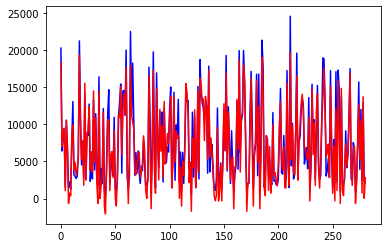

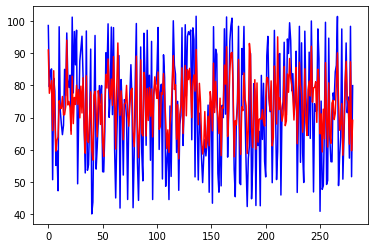

In [45]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn import linear_model
best_rr = linear_model.Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None, normalize=True,
      random_state=None, solver='saga', tol=0.001)
best_rr.fit(X_train, Y_train)
Y_pred = best_rr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold[:,0], 'b')
plt.plot(Y_pred[:,0], 'r')
plt.figure()
plt.plot(Y_fold[:,1], 'b')
plt.plot(Y_pred[:,1], 'r')

r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores_runtime = (absolute_percentage_error(Y_fold[:,0], Y_pred[:,0]))
mape_scores_power = (absolute_percentage_error(Y_fold[:,1], Y_pred[:,1]))

print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE:Runtime \n', mape_scores_runtime)
print('\nMAPE:Power \n', mape_scores_power)


In [ ]:
# 4. K-Nearest Neighbors + Grid Search

In [46]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5, weights='uniform', 
                            algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
# defining parameter range 
param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 9, 10, 13, 15],  
             'weights' : ['uniform', 'distance'],
              'p' : [1, 2, 4, 5, 7 ,10]
             } 
grid = GridSearchCV(neigh, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=2, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=1, weights=uniform, score=-0.012, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] n_neighbors=2, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.874, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] n_neighbors=2, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=1, weights=uniform, score=0.599, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=1, weights=distance, score=-0.008, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=1, weights=distance, score=0.877, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=1, weights=distance, score=0.598, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=2, weights=uniform, score=-0.025, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=2, weights=uniform, score=0.875, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=2, weights=uniform, score=0.533, total=   0.0s
[CV] n_neighbors=2, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=2, weights=distance, score=-0.022, total=   0.0s
[CV] n_neighbors=2, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=2, weights=distance, score=0.878, total=   0.0s
[CV] n_neighbors=2, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=2, weights=distance, score=0.533, total=   0.0s
[CV] n_neighbors=2, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=4, weights=uniform, score=-0.019, total=   0.0s
[CV] n_neighbors=2, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=4, weights=uniform, score=0.873, total=   0.0s
[CV] n_neighbors=2, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=4, weights=uniform, score=0.533, total=   0.0s
[CV] n_neighbors=2, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=4, weights=distance, score=-0.016, total=   0.0s
[CV] n_neighbors=2, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=4, weights=distance, score=0.876, total=   0.0s
[CV] n_neighbors=2, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=4, weights=distance, score=0.533, total=   0.0s
[CV] n_neighbors=2, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=5, weights=uniform, score=-0.036, total=   0.0s
[CV] n_neighbors=2, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=5, weights=uniform, score=0.873, total=   0.0s
[CV] n_neighbors=2, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=5, weights=uniform, score=0.533, total=   0.0s
[CV] n_neighbors=2, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=5, weights=distance, score=-0.034, total=   0.0s
[CV] n_neighbors=2, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=5, weights=distance, score=0.876, total=   0.0s
[CV] n_neighbors=2, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=5, weights=distance, score=0.533, total=   0.0s
[CV] n_neighbors=2, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=7, weights=uniform, score=-0.064, total=   0.0s
[CV] n_neighbors=2, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=7, weights=uniform, score=0.558, total=   0.0s
[CV] n_neighbors=2, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=2, p=7, weights=uniform, score=0.533, total=   0.0s
[CV] n_neighbors=2, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=7, weights=distance, score=-0.063, total=   0.0s
[CV] n_neighbors=2, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=7, weights=distance, score=0.561, total=   0.0s
[CV] n_neighbors=2, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=7, weights=distance, score=0.533, total=   0.0s
[CV] n_neighbors=2, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=uniform, score=-0.043, total=   0.0s
[CV] n_neighbors=2, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=uniform, score=0.558, total=   0.0s
[CV] n_neighbors=2, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=uniform, score=0.534, total=   0.0s
[CV] n_neighbors=2, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=distance, score=-0.042, total=   0.0s
[CV] n_neighbors=2, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=distance, score=0.561, total=   0.0s
[CV] n_neighbors=2, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=2, p=10, weights=distance, score=0.534, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=1, weights=uniform, score=-0.037, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=1, weights=uniform, score=0.885, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=1, weights=uniform, score=0.605, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=1, weights=distance, score=-0.026, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=1, weights=distance, score=0.887, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=1, weights=distance, score=0.605, total=   0.0s
[CV] n_neighbors=3, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=2, weights=uniform, score=0.006, total=   0.0s
[CV] n_neighbors=3, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=2, weights=uniform, score=0.869, total=   0.0s
[CV] n_neighbors=3, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=2, weights=uniform, score=0.521, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=2, weights=distance, score=0.011, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=2, weights=distance, score=0.876, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=2, weights=distance, score=0.522, total=   0.0s
[CV] n_neighbors=3, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=4, weights=uniform, score=0.018, total=   0.0s
[CV] n_neighbors=3, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=4, weights=uniform, score=0.866, total=   0.0s
[CV] n_neighbors=3, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=4, weights=uniform, score=0.521, total=   0.0s
[CV] n_neighbors=3, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=4, weights=distance, score=0.021, total=   0.0s
[CV] n_neighbors=3, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=4, weights=distance, score=0.872, total=   0.0s
[CV] n_neighbors=3, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=4, weights=distance, score=0.521, total=   0.0s
[CV] n_neighbors=3, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=5, weights=uniform, score=-0.001, total=   0.0s
[CV] n_neighbors=3, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=5, weights=uniform, score=0.866, total=   0.0s
[CV] n_neighbors=3, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=5, weights=uniform, score=0.521, total=   0.0s
[CV] n_neighbors=3, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=5, weights=distance, score=0.002, total=   0.0s
[CV] n_neighbors=3, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=5, weights=distance, score=0.872, total=   0.0s
[CV] n_neighbors=3, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=5, weights=distance, score=0.521, total=   0.0s
[CV] n_neighbors=3, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=7, weights=uniform, score=-0.025, total=   0.0s
[CV] n_neighbors=3, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=7, weights=uniform, score=0.497, total=   0.0s
[CV] n_neighbors=3, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=3, p=7, weights=uniform, score=0.521, total=   0.0s
[CV] n_neighbors=3, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=7, weights=distance, score=-0.023, total=   0.0s
[CV] n_neighbors=3, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=7, weights=distance, score=0.503, total=   0.0s
[CV] n_neighbors=3, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=7, weights=distance, score=0.521, total=   0.0s
[CV] n_neighbors=3, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=uniform, score=-0.002, total=   0.0s
[CV] n_neighbors=3, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=uniform, score=0.497, total=   0.0s
[CV] n_neighbors=3, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=uniform, score=0.521, total=   0.0s
[CV] n_neighbors=3, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=distance, score=0.001, total=   0.0s
[CV] n_neighbors=3, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=distance, score=0.503, total=   0.0s
[CV] n_neighbors=3, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=3, p=10, weights=distance, score=0.521, total=   0.0s
[CV] n_neighbors=4, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=1, weights=uniform, score=-0.035, total=   0.0s
[CV] n_neighbors=4, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=1, weights=uniform, score=0.897, total=   0.0s
[CV] n_neighbors=4, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=1, weights=uniform, score=0.645, total=   0.0s
[CV] n_neighbors=4, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=1, weights=distance, score=-0.022, total=   0.0s
[CV] n_neighbors=4, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=1, weights=distance, score=0.897, total=   0.0s
[CV] n_neighbors=4, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=1, weights=distance, score=0.635, total=   0.0s
[CV] n_neighbors=4, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=2, weights=uniform, score=0.005, total=   0.0s
[CV] n_neighbors=4, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=2, weights=uniform, score=0.874, total=   0.0s
[CV] n_neighbors=4, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=2, weights=uniform, score=0.619, total=   0.0s
[CV] n_neighbors=4, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=2, weights=distance, score=0.011, total=   0.0s
[CV] n_neighbors=4, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=2, weights=distance, score=0.882, total=   0.0s
[CV] n_neighbors=4, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=2, weights=distance, score=0.605, total=   0.0s
[CV] n_neighbors=4, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=4, weights=uniform, score=0.039, total=   0.0s
[CV] n_neighbors=4, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=4, weights=uniform, score=0.869, total=   0.0s
[CV] n_neighbors=4, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=4, weights=uniform, score=0.616, total=   0.0s
[CV] n_neighbors=4, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=4, weights=distance, score=0.042, total=   0.0s
[CV] n_neighbors=4, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=4, weights=distance, score=0.877, total=   0.0s
[CV] n_neighbors=4, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=4, weights=distance, score=0.600, total=   0.0s
[CV] n_neighbors=4, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=5, weights=uniform, score=0.017, total=   0.0s
[CV] n_neighbors=4, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=5, weights=uniform, score=0.869, total=   0.0s
[CV] n_neighbors=4, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=5, weights=uniform, score=0.618, total=   0.0s
[CV] n_neighbors=4, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=5, weights=distance, score=0.021, total=   0.0s
[CV] n_neighbors=4, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=5, weights=distance, score=0.877, total=   0.0s
[CV] n_neighbors=4, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=5, weights=distance, score=0.602, total=   0.0s
[CV] n_neighbors=4, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=7, weights=uniform, score=0.000, total=   0.0s
[CV] n_neighbors=4, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=7, weights=uniform, score=0.504, total=   0.0s
[CV] n_neighbors=4, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=4, p=7, weights=uniform, score=0.618, total=   0.0s
[CV] n_neighbors=4, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=7, weights=distance, score=0.003, total=   0.0s
[CV] n_neighbors=4, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=7, weights=distance, score=0.511, total=   0.0s
[CV] n_neighbors=4, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=7, weights=distance, score=0.601, total=   0.0s
[CV] n_neighbors=4, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=uniform, score=0.021, total=   0.0s
[CV] n_neighbors=4, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=uniform, score=0.504, total=   0.0s
[CV] n_neighbors=4, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=uniform, score=0.618, total=   0.0s
[CV] n_neighbors=4, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=distance, score=0.023, total=   0.0s
[CV] n_neighbors=4, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=distance, score=0.511, total=   0.0s
[CV] n_neighbors=4, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=4, p=10, weights=distance, score=0.601, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=1, weights=uniform, score=-0.072, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=1, weights=uniform, score=0.891, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=1, weights=uniform, score=0.682, total=   0.0s
[CV] n_neighbors=5, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=1, weights=distance, score=-0.049, total=   0.0s
[CV] n_neighbors=5, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=1, weights=distance, score=0.894, total=   0.0s
[CV] n_neighbors=5, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=1, weights=distance, score=0.668, total=   0.0s
[CV] n_neighbors=5, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=2, weights=uniform, score=-0.027, total=   0.0s
[CV] n_neighbors=5, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=2, weights=uniform, score=0.880, total=   0.0s
[CV] n_neighbors=5, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=2, weights=uniform, score=0.672, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=2, weights=distance, score=-0.015, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=2, weights=distance, score=0.886, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=2, weights=distance, score=0.657, total=   0.0s
[CV] n_neighbors=5, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=4, weights=uniform, score=0.010, total=   0.0s
[CV] n_neighbors=5, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=4, weights=uniform, score=0.863, total=   0.0s
[CV] n_neighbors=5, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=4, weights=uniform, score=0.674, total=   0.0s
[CV] n_neighbors=5, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=4, weights=distance, score=0.018, total=   0.0s
[CV] n_neighbors=5, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=4, weights=distance, score=0.872, total=   0.0s
[CV] n_neighbors=5, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=4, weights=distance, score=0.655, total=   0.0s
[CV] n_neighbors=5, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=5, weights=uniform, score=-0.006, total=   0.0s
[CV] n_neighbors=5, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=5, weights=uniform, score=0.863, total=   0.0s
[CV] n_neighbors=5, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=5, weights=uniform, score=0.674, total=   0.0s
[CV] n_neighbors=5, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=5, weights=distance, score=0.001, total=   0.0s
[CV] n_neighbors=5, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=5, weights=distance, score=0.871, total=   0.0s
[CV] n_neighbors=5, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=5, weights=distance, score=0.655, total=   0.0s
[CV] n_neighbors=5, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=7, weights=uniform, score=-0.023, total=   0.0s
[CV] n_neighbors=5, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=7, weights=uniform, score=0.507, total=   0.0s
[CV] n_neighbors=5, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=5, p=7, weights=uniform, score=0.674, total=   0.0s
[CV] n_neighbors=5, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=7, weights=distance, score=-0.016, total=   0.0s
[CV] n_neighbors=5, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=7, weights=distance, score=0.515, total=   0.0s
[CV] n_neighbors=5, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=7, weights=distance, score=0.655, total=   0.0s
[CV] n_neighbors=5, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=uniform, score=0.002, total=   0.0s
[CV] n_neighbors=5, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=uniform, score=0.507, total=   0.0s
[CV] n_neighbors=5, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=uniform, score=0.672, total=   0.0s
[CV] n_neighbors=5, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=distance, score=0.009, total=   0.0s
[CV] n_neighbors=5, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=distance, score=0.515, total=   0.0s
[CV] n_neighbors=5, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=5, p=10, weights=distance, score=0.653, total=   0.0s
[CV] n_neighbors=6, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=1, weights=uniform, score=-0.092, total=   0.0s
[CV] n_neighbors=6, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=1, weights=uniform, score=0.884, total=   0.0s
[CV] n_neighbors=6, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=1, weights=uniform, score=0.708, total=   0.0s
[CV] n_neighbors=6, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=1, weights=distance, score=-0.066, total=   0.0s
[CV] n_neighbors=6, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=1, weights=distance, score=0.889, total=   0.0s
[CV] n_neighbors=6, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=1, weights=distance, score=0.694, total=   0.0s
[CV] n_neighbors=6, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=2, weights=uniform, score=-0.057, total=   0.0s
[CV] n_neighbors=6, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=2, weights=uniform, score=0.881, total=   0.0s
[CV] n_neighbors=6, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=2, weights=uniform, score=0.704, total=   0.0s
[CV] n_neighbors=6, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=2, weights=distance, score=-0.043, total=   0.0s
[CV] n_neighbors=6, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=2, weights=distance, score=0.886, total=   0.0s
[CV] n_neighbors=6, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=2, weights=distance, score=0.690, total=   0.0s
[CV] n_neighbors=6, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=4, weights=uniform, score=0.022, total=   0.0s
[CV] n_neighbors=6, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=4, weights=uniform, score=0.862, total=   0.0s
[CV] n_neighbors=6, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=4, weights=uniform, score=0.700, total=   0.0s
[CV] n_neighbors=6, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=4, weights=distance, score=0.032, total=   0.0s
[CV] n_neighbors=6, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=4, weights=distance, score=0.870, total=   0.0s
[CV] n_neighbors=6, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=4, weights=distance, score=0.683, total=   0.0s
[CV] n_neighbors=6, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=5, weights=uniform, score=0.003, total=   0.0s
[CV] n_neighbors=6, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=5, weights=uniform, score=0.861, total=   0.0s
[CV] n_neighbors=6, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=5, weights=uniform, score=0.700, total=   0.0s
[CV] n_neighbors=6, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=5, weights=distance, score=0.012, total=   0.0s
[CV] n_neighbors=6, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=5, weights=distance, score=0.869, total=   0.0s
[CV] n_neighbors=6, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=5, weights=distance, score=0.683, total=   0.0s
[CV] n_neighbors=6, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=7, weights=uniform, score=-0.020, total=   0.0s
[CV] n_neighbors=6, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=7, weights=uniform, score=0.503, total=   0.0s
[CV] n_neighbors=6, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=6, p=7, weights=uniform, score=0.700, total=   0.0s
[CV] n_neighbors=6, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=7, weights=distance, score=-0.012, total=   0.0s
[CV] n_neighbors=6, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=7, weights=distance, score=0.511, total=   0.0s
[CV] n_neighbors=6, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=7, weights=distance, score=0.682, total=   0.0s
[CV] n_neighbors=6, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=uniform, score=0.005, total=   0.0s
[CV] n_neighbors=6, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=uniform, score=0.503, total=   0.0s
[CV] n_neighbors=6, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=uniform, score=0.699, total=   0.0s
[CV] n_neighbors=6, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=distance, score=0.013, total=   0.0s
[CV] n_neighbors=6, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=distance, score=0.511, total=   0.0s
[CV] n_neighbors=6, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=6, p=10, weights=distance, score=0.681, total=   0.0s
[CV] n_neighbors=7, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=1, weights=uniform, score=-0.097, total=   0.0s
[CV] n_neighbors=7, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=1, weights=uniform, score=0.882, total=   0.0s
[CV] n_neighbors=7, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=1, weights=uniform, score=0.713, total=   0.0s
[CV] n_neighbors=7, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=1, weights=distance, score=-0.072, total=   0.0s
[CV] n_neighbors=7, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=1, weights=distance, score=0.887, total=   0.0s
[CV] n_neighbors=7, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=1, weights=distance, score=0.700, total=   0.0s
[CV] n_neighbors=7, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=2, weights=uniform, score=-0.066, total=   0.0s
[CV] n_neighbors=7, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=2, weights=uniform, score=0.874, total=   0.0s
[CV] n_neighbors=7, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=2, weights=uniform, score=0.715, total=   0.0s
[CV] n_neighbors=7, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=2, weights=distance, score=-0.050, total=   0.0s
[CV] n_neighbors=7, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=2, weights=distance, score=0.881, total=   0.0s
[CV] n_neighbors=7, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=2, weights=distance, score=0.701, total=   0.0s
[CV] n_neighbors=7, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=4, weights=uniform, score=-0.020, total=   0.0s
[CV] n_neighbors=7, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=4, weights=uniform, score=0.868, total=   0.0s
[CV] n_neighbors=7, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=4, weights=uniform, score=0.710, total=   0.0s
[CV] n_neighbors=7, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=4, weights=distance, score=-0.008, total=   0.0s
[CV] n_neighbors=7, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=4, weights=distance, score=0.874, total=   0.0s
[CV] n_neighbors=7, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=4, weights=distance, score=0.694, total=   0.0s
[CV] n_neighbors=7, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=5, weights=uniform, score=-0.041, total=   0.0s
[CV] n_neighbors=7, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=5, weights=uniform, score=0.868, total=   0.0s
[CV] n_neighbors=7, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=5, weights=uniform, score=0.710, total=   0.0s
[CV] n_neighbors=7, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=5, weights=distance, score=-0.029, total=   0.0s
[CV] n_neighbors=7, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=5, weights=distance, score=0.874, total=   0.0s
[CV] n_neighbors=7, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=5, weights=distance, score=0.694, total=   0.0s
[CV] n_neighbors=7, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=7, weights=uniform, score=-0.060, total=   0.0s
[CV] n_neighbors=7, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=7, weights=uniform, score=0.519, total=   0.0s
[CV] n_neighbors=7, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=7, p=7, weights=uniform, score=0.710, total=   0.0s
[CV] n_neighbors=7, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=7, weights=distance, score=-0.049, total=   0.0s
[CV] n_neighbors=7, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=7, weights=distance, score=0.525, total=   0.0s
[CV] n_neighbors=7, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=7, weights=distance, score=0.693, total=   0.0s
[CV] n_neighbors=7, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=uniform, score=-0.038, total=   0.0s
[CV] n_neighbors=7, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=uniform, score=0.519, total=   0.0s
[CV] n_neighbors=7, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=uniform, score=0.711, total=   0.0s
[CV] n_neighbors=7, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=distance, score=-0.027, total=   0.0s
[CV] n_neighbors=7, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=distance, score=0.525, total=   0.0s
[CV] n_neighbors=7, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=7, p=10, weights=distance, score=0.694, total=   0.0s
[CV] n_neighbors=9, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=1, weights=uniform, score=-0.122, total=   0.0s
[CV] n_neighbors=9, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=1, weights=uniform, score=0.868, total=   0.0s
[CV] n_neighbors=9, p=1, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=1, weights=uniform, score=0.731, total=   0.0s
[CV] n_neighbors=9, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=1, weights=distance, score=-0.091, total=   0.0s
[CV] n_neighbors=9, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=1, weights=distance, score=0.877, total=   0.0s
[CV] n_neighbors=9, p=1, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=1, weights=distance, score=0.719, total=   0.0s
[CV] n_neighbors=9, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=2, weights=uniform, score=-0.111, total=   0.0s
[CV] n_neighbors=9, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=2, weights=uniform, score=0.868, total=   0.0s
[CV] n_neighbors=9, p=2, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=2, weights=uniform, score=0.740, total=   0.0s
[CV] n_neighbors=9, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=2, weights=distance, score=-0.091, total=   0.0s
[CV] n_neighbors=9, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=2, weights=distance, score=0.875, total=   0.0s
[CV] n_neighbors=9, p=2, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=2, weights=distance, score=0.729, total=   0.0s
[CV] n_neighbors=9, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=4, weights=uniform, score=-0.031, total=   0.0s
[CV] n_neighbors=9, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=4, weights=uniform, score=0.865, total=   0.0s
[CV] n_neighbors=9, p=4, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=4, weights=uniform, score=0.727, total=   0.0s
[CV] n_neighbors=9, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=4, weights=distance, score=-0.016, total=   0.0s
[CV] n_neighbors=9, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=4, weights=distance, score=0.871, total=   0.0s
[CV] n_neighbors=9, p=4, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=4, weights=distance, score=0.714, total=   0.1s
[CV] n_neighbors=9, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=5, weights=uniform, score=-0.041, total=   0.0s
[CV] n_neighbors=9, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=5, weights=uniform, score=0.865, total=   0.0s
[CV] n_neighbors=9, p=5, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=5, weights=uniform, score=0.725, total=   0.0s
[CV] n_neighbors=9, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=5, weights=distance, score=-0.027, total=   0.0s
[CV] n_neighbors=9, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=5, weights=distance, score=0.871, total=   0.0s
[CV] n_neighbors=9, p=5, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=5, weights=distance, score=0.712, total=   0.0s
[CV] n_neighbors=9, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=7, weights=uniform, score=-0.038, total=   0.0s
[CV] n_neighbors=9, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=7, weights=uniform, score=0.488, total=   0.0s
[CV] n_neighbors=9, p=7, weights=uniform .............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] . n_neighbors=9, p=7, weights=uniform, score=0.725, total=   0.0s
[CV] n_neighbors=9, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=7, weights=distance, score=-0.025, total=   0.0s
[CV] n_neighbors=9, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=7, weights=distance, score=0.493, total=   0.0s
[CV] n_neighbors=9, p=7, weights=distance ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=7, weights=distance, score=0.711, total=   0.0s
[CV] n_neighbors=9, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=uniform, score=-0.031, total=   0.0s
[CV] n_neighbors=9, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=uniform, score=0.488, total=   0.0s
[CV] n_neighbors=9, p=10, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=uniform, score=0.727, total=   0.0s
[CV] n_neighbors=9, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=distance, score=-0.018, total=   0.0s
[CV] n_neighbors=9, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=distance, score=0.493, total=   0.0s
[CV] n_neighbors=9, p=10, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=9, p=10, weights=distance, score=0.713, total=   0.0s
[CV] n_neighbors=10, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=uniform, score=-0.157, total=   0.0s
[CV] n_neighbors=10, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=uniform, score=0.864, total=   0.0s
[CV] n_neighbors=10, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=uniform, score=0.739, total=   0.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=distance, score=-0.116, total=   0.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=distance, score=0.875, total=   0.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=1, weights=distance, score=0.728, total=   0.0s
[CV] n_neighbors=10, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=uniform, score=-0.136, total=   0.0s
[CV] n_neighbors=10, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=uniform, score=0.863, total=   0.0s
[CV] n_neighbors=10, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=uniform, score=0.748, total=   0.0s
[CV] n_neighbors=10, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=distance, score=-0.110, total=   0.0s
[CV] n_neighbors=10, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=distance, score=0.869, total=   0.0s
[CV] n_neighbors=10, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=2, weights=distance, score=0.738, total=   0.0s
[CV] n_neighbors=10, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=uniform, score=-0.049, total=   0.0s
[CV] n_neighbors=10, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=uniform, score=0.861, total=   0.0s
[CV] n_neighbors=10, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=uniform, score=0.733, total=   0.0s
[CV] n_neighbors=10, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=distance, score=-0.029, total=   0.0s
[CV] n_neighbors=10, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=distance, score=0.866, total=   0.0s
[CV] n_neighbors=10, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=4, weights=distance, score=0.722, total=   0.0s
[CV] n_neighbors=10, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=uniform, score=-0.057, total=   0.0s
[CV] n_neighbors=10, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=uniform, score=0.861, total=   0.0s
[CV] n_neighbors=10, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=uniform, score=0.732, total=   0.0s
[CV] n_neighbors=10, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=distance, score=-0.037, total=   0.0s
[CV] n_neighbors=10, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=distance, score=0.866, total=   0.0s
[CV] n_neighbors=10, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=5, weights=distance, score=0.720, total=   0.0s
[CV] n_neighbors=10, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=uniform, score=-0.047, total=   0.0s
[CV] n_neighbors=10, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=uniform, score=0.484, total=   0.0s
[CV] n_neighbors=10, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=uniform, score=0.730, total=   0.0s
[CV] n_neighbors=10, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=distance, score=-0.028, total=   0.0s
[CV] n_neighbors=10, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=distance, score=0.488, total=   0.0s
[CV] n_neighbors=10, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=7, weights=distance, score=0.717, total=   0.0s
[CV] n_neighbors=10, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=uniform, score=-0.044, total=   0.0s
[CV] n_neighbors=10, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=uniform, score=0.484, total=   0.0s
[CV] n_neighbors=10, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=uniform, score=0.731, total=   0.0s
[CV] n_neighbors=10, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=distance, score=-0.025, total=   0.0s
[CV] n_neighbors=10, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=distance, score=0.488, total=   0.0s
[CV] n_neighbors=10, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=10, p=10, weights=distance, score=0.719, total=   0.0s
[CV] n_neighbors=13, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=uniform, score=-0.184, total=   0.0s
[CV] n_neighbors=13, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=uniform, score=0.853, total=   0.0s
[CV] n_neighbors=13, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=uniform, score=0.739, total=   0.0s
[CV] n_neighbors=13, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=distance, score=-0.137, total=   0.0s
[CV] n_neighbors=13, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=distance, score=0.866, total=   0.0s
[CV] n_neighbors=13, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=1, weights=distance, score=0.731, total=   0.0s
[CV] n_neighbors=13, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=uniform, score=-0.182, total=   0.0s
[CV] n_neighbors=13, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=uniform, score=0.852, total=   0.0s
[CV] n_neighbors=13, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=uniform, score=0.751, total=   0.0s
[CV] n_neighbors=13, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=distance, score=-0.150, total=   0.0s
[CV] n_neighbors=13, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=distance, score=0.859, total=   0.0s
[CV] n_neighbors=13, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=2, weights=distance, score=0.744, total=   0.0s
[CV] n_neighbors=13, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=uniform, score=-0.109, total=   0.0s
[CV] n_neighbors=13, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=uniform, score=0.847, total=   0.0s
[CV] n_neighbors=13, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=uniform, score=0.742, total=   0.0s
[CV] n_neighbors=13, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=distance, score=-0.083, total=   0.0s
[CV] n_neighbors=13, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=distance, score=0.852, total=   0.0s
[CV] n_neighbors=13, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=4, weights=distance, score=0.734, total=   0.0s
[CV] n_neighbors=13, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=uniform, score=-0.103, total=   0.0s
[CV] n_neighbors=13, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=uniform, score=0.846, total=   0.0s
[CV] n_neighbors=13, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=uniform, score=0.741, total=   0.0s
[CV] n_neighbors=13, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=distance, score=-0.078, total=   0.0s
[CV] n_neighbors=13, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=distance, score=0.851, total=   0.0s
[CV] n_neighbors=13, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=5, weights=distance, score=0.732, total=   0.0s
[CV] n_neighbors=13, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=uniform, score=-0.087, total=   0.0s
[CV] n_neighbors=13, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=uniform, score=0.460, total=   0.0s
[CV] n_neighbors=13, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=uniform, score=0.737, total=   0.0s
[CV] n_neighbors=13, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=distance, score=-0.063, total=   0.0s
[CV] n_neighbors=13, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=distance, score=0.464, total=   0.0s
[CV] n_neighbors=13, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=7, weights=distance, score=0.727, total=   0.0s
[CV] n_neighbors=13, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=uniform, score=-0.089, total=   0.0s
[CV] n_neighbors=13, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=uniform, score=0.460, total=   0.0s
[CV] n_neighbors=13, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=uniform, score=0.737, total=   0.0s
[CV] n_neighbors=13, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=distance, score=-0.065, total=   0.0s
[CV] n_neighbors=13, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=distance, score=0.463, total=   0.0s
[CV] n_neighbors=13, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=13, p=10, weights=distance, score=0.728, total=   0.0s
[CV] n_neighbors=15, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=uniform, score=-0.228, total=   0.0s
[CV] n_neighbors=15, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=uniform, score=0.837, total=   0.0s
[CV] n_neighbors=15, p=1, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=uniform, score=0.732, total=   0.0s
[CV] n_neighbors=15, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=distance, score=-0.164, total=   0.0s
[CV] n_neighbors=15, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=distance, score=0.853, total=   0.0s
[CV] n_neighbors=15, p=1, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=1, weights=distance, score=0.726, total=   0.0s
[CV] n_neighbors=15, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=uniform, score=-0.224, total=   0.0s
[CV] n_neighbors=15, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=uniform, score=0.835, total=   0.0s
[CV] n_neighbors=15, p=2, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=uniform, score=0.738, total=   0.0s
[CV] n_neighbors=15, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=distance, score=-0.179, total=   0.0s
[CV] n_neighbors=15, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=distance, score=0.845, total=   0.0s
[CV] n_neighbors=15, p=2, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=2, weights=distance, score=0.733, total=   0.0s
[CV] n_neighbors=15, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=uniform, score=-0.143, total=   0.0s
[CV] n_neighbors=15, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=uniform, score=0.833, total=   0.0s
[CV] n_neighbors=15, p=4, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=uniform, score=0.744, total=   0.0s
[CV] n_neighbors=15, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=distance, score=-0.105, total=   0.0s
[CV] n_neighbors=15, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=distance, score=0.840, total=   0.0s
[CV] n_neighbors=15, p=4, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=4, weights=distance, score=0.737, total=   0.0s
[CV] n_neighbors=15, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=uniform, score=-0.131, total=   0.0s
[CV] n_neighbors=15, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=uniform, score=0.832, total=   0.0s
[CV] n_neighbors=15, p=5, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=uniform, score=0.744, total=   0.0s
[CV] n_neighbors=15, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=distance, score=-0.095, total=   0.0s
[CV] n_neighbors=15, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=distance, score=0.839, total=   0.0s
[CV] n_neighbors=15, p=5, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=5, weights=distance, score=0.737, total=   0.0s
[CV] n_neighbors=15, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=uniform, score=-0.125, total=   0.0s
[CV] n_neighbors=15, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=uniform, score=0.412, total=   0.0s
[CV] n_neighbors=15, p=7, weights=uniform ............................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=uniform, score=0.740, total=   0.0s
[CV] n_neighbors=15, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=distance, score=-0.090, total=   0.0s
[CV] n_neighbors=15, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=distance, score=0.418, total=   0.0s
[CV] n_neighbors=15, p=7, weights=distance ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=7, weights=distance, score=0.733, total=   0.0s
[CV] n_neighbors=15, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=uniform, score=-0.132, total=   0.0s
[CV] n_neighbors=15, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=uniform, score=0.412, total=   0.0s
[CV] n_neighbors=15, p=10, weights=uniform ...........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=uniform, score=0.740, total=   0.0s
[CV] n_neighbors=15, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=distance, score=-0.096, total=   0.0s
[CV] n_neighbors=15, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=distance, score=0.418, total=   0.0s
[CV] n_neighbors=15, p=10, weights=distance ..........................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  n_neighbors=15, p=10, weights=distance, score=0.732, total=   0.0s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   10.0s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 6, 'p': 4, 'weights': 'distance'}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=4,
                    weights='distance')


# 10 fold cross validation for best KNN Regressor

MSE: 
 1778935.9755667243

R2: 
 0.48988201114888813

MAPE:Runtime 
 0.3801136368799117

MAPE:Power 
 0.18691452570462147


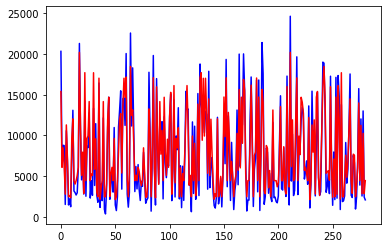

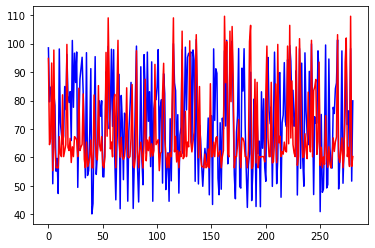

In [47]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.neighbors import KNeighborsRegressor
best_knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=4,
                    weights='distance')
best_knn.fit(X_train, Y_train)
Y_pred = best_knn.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold[:,0], 'b')
plt.plot(Y_pred[:,0], 'r')
plt.figure()
plt.plot(Y_fold[:,1], 'b')
plt.plot(Y_pred[:,1], 'r')

r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores_runtime = (absolute_percentage_error(Y_fold[:,0], Y_pred[:,0]))
mape_scores_power = (absolute_percentage_error(Y_fold[:,1], Y_pred[:,1]))

print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE:Runtime \n', mape_scores_runtime)
print('\nMAPE:Power \n', mape_scores_power)


# 5. Gaussian Process Regressor (Marcov Chain Monte Carlo) + Grid Search

In [48]:
from sklearn.gaussian_process import GaussianProcessRegressor
gpr = GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0 , 
                               normalize_y= True, copy_X_train=True, random_state= None)
# defining parameter range 
param_grid = {'alpha': [1e-10, 1e-9, 1e-5, 1e-2],  
             'normalize_y' : [True, False],
                         } 
grid = GridSearchCV(gpr, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-10, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] .... alpha=1e-10, normalize_y=True, score=-132.712, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=1e-10, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-10, normalize_y=True, score=-0.335, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=1e-10, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-10, normalize_y=True, score=0.076, total=   0.0s
[CV] alpha=1e-10, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ... alpha=1e-10, normalize_y=False, score=-134.010, total=   0.0s
[CV] alpha=1e-10, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ..... alpha=1e-10, normalize_y=False, score=-0.044, total=   0.0s
[CV] alpha=1e-10, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-10, normalize_y=False, score=0.098, total=   0.0s
[CV] alpha=1e-09, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] .... alpha=1e-09, normalize_y=True, score=-141.194, total=   0.0s
[CV] alpha=1e-09, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-09, normalize_y=True, score=-0.328, total=   0.0s
[CV] alpha=1e-09, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-09, normalize_y=True, score=0.076, total=   0.0s
[CV] alpha=1e-09, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ... alpha=1e-09, normalize_y=False, score=-142.569, total=   0.0s
[CV] alpha=1e-09, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ..... alpha=1e-09, normalize_y=False, score=-0.039, total=   0.0s
[CV] alpha=1e-09, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-09, normalize_y=False, score=0.098, total=   0.0s
[CV] alpha=1e-05, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ..... alpha=1e-05, normalize_y=True, score=-56.715, total=   0.0s
[CV] alpha=1e-05, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-05, normalize_y=True, score=-0.283, total=   0.0s
[CV] alpha=1e-05, normalize_y=True ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=1e-05, normalize_y=True, score=0.076, total=   0.0s
[CV] alpha=1e-05, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] .... alpha=1e-05, normalize_y=False, score=-57.496, total=   0.0s
[CV] alpha=1e-05, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-05, normalize_y=False, score=0.007, total=   0.0s
[CV] alpha=1e-05, normalize_y=False ..................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ...... alpha=1e-05, normalize_y=False, score=0.098, total=   0.0s
[CV] alpha=0.01, normalize_y=True ....................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ........ alpha=0.01, normalize_y=True, score=0.196, total=   0.0s
[CV] alpha=0.01, normalize_y=True ....................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=0.01, normalize_y=True, score=-0.281, total=   0.0s
[CV] alpha=0.01, normalize_y=True ....................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ........ alpha=0.01, normalize_y=True, score=0.076, total=   0.0s
[CV] alpha=0.01, normalize_y=False ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=0.01, normalize_y=False, score=0.346, total=   0.0s
[CV] alpha=0.01, normalize_y=False ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=0.01, normalize_y=False, score=0.009, total=   0.0s
[CV] alpha=0.01, normalize_y=False ...................................


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV] ....... alpha=0.01, normalize_y=False, score=0.098, total=   0.0s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.5s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.01, 'normalize_y': False}
GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)


# 10 fold cross validation for best Gaussian Process Regressor

MSE: 
 9633626.4430653

R2: 
 0.2858054890251931

MAPE:Runtime 
 1.137476431871089

MAPE:Power 
 0.19524698400928872


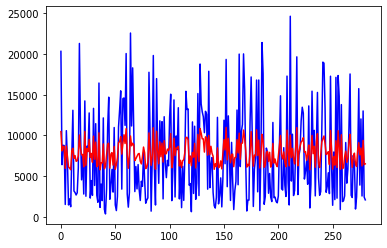

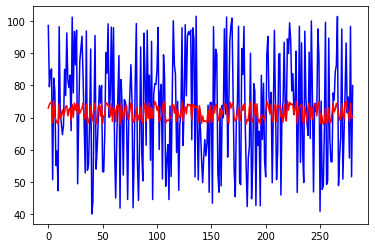

In [49]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.gaussian_process import GaussianProcessRegressor
best_gpr = GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
best_gpr.fit(X_train, Y_train)
Y_pred = best_gpr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold[:,0], 'b')
plt.plot(Y_pred[:,0], 'r')
plt.figure()
plt.plot(Y_fold[:,1], 'b')
plt.plot(Y_pred[:,1], 'r')

r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores_runtime = (absolute_percentage_error(Y_fold[:,0], Y_pred[:,0]))
mape_scores_power = (absolute_percentage_error(Y_fold[:,1], Y_pred[:,1]))

print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE:Runtime \n', mape_scores_runtime)
print('\nMAPE:Power \n', mape_scores_power)


# 6. Decision Tree + Grid Search

In [50]:
from sklearn.tree import DecisionTreeRegressor #  ' min_samples_split' : [2],
regressor = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, 
                                  min_samples_split=2,
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                  max_features=None, random_state=None, max_leaf_nodes=None, 
                                  min_impurity_decrease=0.0, min_impurity_split=None)
# defining parameter range 
param_grid = {'criterion': ['mse','friedman_mse', 'mae'],  
              'splitter' : ['best', 'random'], 
              'max_depth': [2,3,4,5,7,9,10,15,20,30 ],
              'min_samples_leaf' : [1, 2,3,  4, 5,6, 7],
              'max_features' : ['auto', 'sqrt', 'log2'],
             } 
grid = GridSearchCV(regressor, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.145, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.670, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.838, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.633, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.249, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.670, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.458, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.356, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.009, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.670, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.327, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.435, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.223, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.670, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.166, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.582, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.257, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.670, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.098, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.595, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.312, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.145, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.670, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.745, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.606, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.034, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.670, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.054, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.606, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.546, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.458, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.606, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.315, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.598, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-1.398, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.391, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.155, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.525, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.066, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.891, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.228, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.458, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.155, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.449, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.961, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.045, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.336, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.587, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.353, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.840, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.111, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.199, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.045, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.498, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.868, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.957, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.317, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.528, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.648, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.840, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-1.284, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.122, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.365, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.657, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.054, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.084, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.337, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.497, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.320, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.874, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.019, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.088, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.080, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.268, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.838, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.276, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.132, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.606, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.173, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.019, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.181, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.043, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.252, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.840, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.051, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.382, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.440, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.904, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.379, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.045, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.550, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.753, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.075, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.682, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.787, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.030, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.168, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.385, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.874, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.360, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.202, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.408, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.544, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.421, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.595, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.526, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.519, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.216, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.174, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.347, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.463, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.180, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.681, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.037, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.728, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.683, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.340, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.369, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.544, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.259, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.404, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.244, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.203, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.724, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.613, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.743, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.310, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.295, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.515, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.501, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.550, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.712, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.190, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.378, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.368, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.173, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.632, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.626, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.618, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.891, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.154, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.504, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.166, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.842, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.366, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.349, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.362, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.371, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.627, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.184, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.120, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.177, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.652, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.716, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.201, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.639, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.390, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.392, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.235, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.474, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.019, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.638, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.722, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.349, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.061, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.486, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.561, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.058, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.336, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.179, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.519, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.367, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.278, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.634, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.710, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.200, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.686, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.633, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.145, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.110, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.217, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.717, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.614, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.509, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.197, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.177, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.655, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=0.538, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.166, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.570, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.223, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.302, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.087, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.311, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.086, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.123, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.304, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.415, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.577, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.664, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.235, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.589, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.153, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.096, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.562, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.757, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.327, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.213, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.420, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.303, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.397, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.581, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.675, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.368, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.571, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.767, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.721, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.316, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.581, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.575, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.334, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.357, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.784, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.029, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.607, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.780, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.602, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.353, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.485, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.016, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.470, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.334, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.727, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.772, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.515, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.229, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.295, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.358, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.727, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.545, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.610, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.791, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.438, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.358, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.718, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.545, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.594, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.728, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.382, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.083, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.069, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.642, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.685, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.041, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.466, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.120, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.166, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.306, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.081, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.215, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.089, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.592, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.156, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.787, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.162, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.074, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.066, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.423, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.131, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.529, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.501, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.700, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.354, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.402, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.102, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.466, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.360, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.141, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.478, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.413, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.303, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.121, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.701, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.266, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.236, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.264, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.817, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.693, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.477, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.320, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.161, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.466, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.373, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.727, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.622, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.643, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=0.315, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.151, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.077, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.456, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.488, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.489, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.607, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.317, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.674, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.294, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.542, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.482, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.122, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.754, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.113, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.102, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.665, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.100, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.220, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.280, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.339, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.285, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.128, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.246, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.622, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.225, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.206, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.352, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.833, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.754, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.364, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.399, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.579, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.711, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.790, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.810, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.523, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.318, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.360, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.590, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.002, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.674, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.517, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.591, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.602, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.076, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.724, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.554, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.608, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.773, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.570, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.475, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.760, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.468, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.327, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.824, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.570, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.442, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.560, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.629, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.403, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.574, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.672, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.734, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.690, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.502, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.686, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.508, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.202, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.432, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.256, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.080, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.628, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.619, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.160, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.739, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.719, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.006, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.163, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.788, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.568, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.133, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.325, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.012, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.824, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.475, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.293, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.770, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.077, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.101, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.175, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.352, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.233, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.682, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.399, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.106, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.019, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.315, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.226, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.433, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.370, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.204, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.087, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.548, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.661, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.407, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.267, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.327, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.164, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.648, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.236, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.127, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.047, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.018, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.046, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.291, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.404, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.049, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.704, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.668, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.218, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.160, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.023, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.673, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.771, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.235, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.497, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.401, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.396, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.102, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.352, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.077, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.209, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.526, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.490, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.122, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.377, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.431, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.733, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.650, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.470, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.615, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.011, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=0.818, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=0.600, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.188, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.668, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.562, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.312, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.391, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.593, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.478, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.715, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.726, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.327, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.412, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.585, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.372, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.523, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.610, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.844, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.083, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.784, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.521, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.245, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.403, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.796, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.477, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.759, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.526, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.627, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.478, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.085, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.244, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.531, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.359, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.573, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.297, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.800, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.178, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.098, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.093, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.264, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.062, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.503, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.058, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.612, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.431, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.036, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.447, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.214, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.255, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.570, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.293, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.721, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.782, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.069, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.790, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.396, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.212, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.403, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.061, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.647, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.524, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.581, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.291, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.108, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.709, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.214, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.324, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.255, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.210, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.100, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.176, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.359, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.389, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.530, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.464, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.083, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.673, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.057, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.032, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.824, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.565, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.065, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.846, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.315, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.006, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.421, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.555, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.667, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.258, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.704, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.356, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.125, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.642, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.285, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.221, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.609, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.480, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.165, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.434, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.364, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.336, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.496, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.208, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.264, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.082, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.713, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.050, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.674, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.486, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.114, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.604, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.596, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.439, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.490, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.627, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.137, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.721, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.527, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.664, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.748, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.311, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.402, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.781, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.261, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.824, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.615, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.577, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.605, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.585, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.336, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.811, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.448, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.245, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.410, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.555, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.592, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.794, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.557, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.593, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.359, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.052, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.450, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.029, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.806, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.794, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.399, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.657, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.508, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.163, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.634, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.047, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.025, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.461, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.381, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.152, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.867, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.777, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.735, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.487, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.001, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.845, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.371, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.140, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.464, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.219, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.469, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.421, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.799, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.160, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.517, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.265, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.469, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.804, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.255, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.714, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.455, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.788, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.359, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.279, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.630, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.332, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.519, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.422, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.227, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.760, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.183, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.065, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.875, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.781, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.461, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.804, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.396, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.012, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.854, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.381, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.151, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.560, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.198, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.002, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.307, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.205, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.135, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.529, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.274, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.089, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.681, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.451, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.374, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.578, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.589, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.037, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.818, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.473, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.370, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.220, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.178, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.108, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.598, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.536, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.614, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.458, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.679, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.470, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.441, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.013, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.676, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.835, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.592, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.162, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.612, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.565, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.319, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.768, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.588, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.117, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.848, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.660, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.327, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.727, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.508, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.852, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.576, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.577, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.791, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.388, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.687, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.439, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.245, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.402, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.154, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.727, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.520, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.182, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.398, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.557, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.048, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.599, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.628, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.573, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.036, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.805, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.543, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.046, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.124, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.032, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.851, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.101, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.125, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.848, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.300, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.008, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.798, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.177, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.792, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.464, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.146, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.786, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.552, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.279, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.271, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.450, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.079, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.626, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.100, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.724, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.486, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.234, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.275, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.090, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.406, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.413, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.811, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.708, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.682, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.502, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.312, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.059, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.497, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.785, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.065, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.489, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.635, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.049, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.844, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.777, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.212, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.755, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.657, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.015, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.755, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.792, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.114, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.599, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.315, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.020, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.866, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.100, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.112, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.358, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.384, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.401, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.706, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.451, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.660, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.061, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.225, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.501, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.507, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.198, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.311, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.360, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.131, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.391, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.378, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.535, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.045, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.538, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.617, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.318, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.795, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.591, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.006, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.516, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.574, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.820, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.295, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.746, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.532, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.009, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.800, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.514, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.195, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.667, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.561, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.571, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.410, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.555, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.138, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.775, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.365, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.301, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.767, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.415, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.819, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.448, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.237, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.345, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.556, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.755, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.766, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.438, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.059, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.845, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.378, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.071, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.281, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.049, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.872, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.042, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.856, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.572, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.076, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.453, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.814, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.108, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.450, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.150, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.823, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.376, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.166, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.517, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.436, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.637, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.229, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.535, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.438, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.744, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.579, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.713, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.370, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.747, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.318, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.365, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.743, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.419, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.059, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.853, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.754, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.009, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.238, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.675, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.177, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.854, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.789, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.128, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.613, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.480, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.716, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.754, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.143, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.006, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.751, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.650, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.665, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.390, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.826, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.805, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.177, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.516, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.106, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.052, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.570, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.391, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.231, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.097, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.071, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.376, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.133, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.244, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.657, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=0.783, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.450, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=0.804, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=0.538, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.319, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.821, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.591, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.072, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.843, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.699, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.327, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.561, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.682, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.116, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.316, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.720, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.584, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.751, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.683, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.515, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.245, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.685, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.552, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.638, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.773, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.566, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.593, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.398, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.555, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.208, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.441, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.329, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.722, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.556, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.362, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.191, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.046, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.784, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.379, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.462, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.783, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.137, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.765, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.771, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.017, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.566, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.475, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.002, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.827, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.280, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.100, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.392, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.132, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.447, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.463, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.211, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.451, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.205, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.741, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.448, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.207, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.577, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.343, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.661, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.646, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.266, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.614, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.405, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.129, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.652, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.223, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.168, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.653, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.181, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.250, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.059, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.838, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.628, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.049, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.860, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.026, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.255, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.520, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.303, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.633, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.348, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.160, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.784, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.529, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.020, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.832, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.463, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.217, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.645, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.238, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.069, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.744, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.482, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.087, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.262, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.106, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.395, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.241, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.463, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.365, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.436, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.668, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.401, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.336, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=0.771, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=0.535, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.165, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=0.853, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=0.538, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.318, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.716, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.591, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.171, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.453, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.497, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.311, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.407, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.584, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.125, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.835, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.316, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.349, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.584, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.654, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.858, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.323, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.825, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.465, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.486, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.537, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.130, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.687, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.557, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.267, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.242, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.611, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.599, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.768, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.811, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.022, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.753, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.625, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.065, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.577, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.021, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.818, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.096, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.167, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.824, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.021, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.602, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.136, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.299, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.654, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.344, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.783, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.642, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.009, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.785, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.128, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.165, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.197, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.366, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.195, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.752, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.492, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.735, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.081, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.768, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.183, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.331, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.665, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.324, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.082, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.813, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.461, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.690, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.458, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.353, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.069, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.592, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.775, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.039, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.634, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.264, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.049, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.400, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.795, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.121, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.833, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.352, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.075, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.846, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.606, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.075, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.675, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.315, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.020, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.723, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.544, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.553, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.413, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.189, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.772, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.469, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.797, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.771, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.108, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.757, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.581, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.042, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.190, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.223, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.077, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.022, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.201, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.284, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=0.584, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.553, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=0.453, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, score=0.584, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.901, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.141, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.538, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.584, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.579, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.177, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.178, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.584, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.745, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.431, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.613, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.584, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.838, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.555, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.512, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.584, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.420, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.531, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.379, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.584, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.579, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.234, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.386, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.582, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.554, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.682, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.413, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.268, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.458, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.155, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.252, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.019, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.056, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.613, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.438, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.401, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.644, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.840, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.221, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.385, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.139, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.282, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.497, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.346, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.758, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.377, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.028, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.033, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.639, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.684, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.379, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.161, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.077, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.053, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.045, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.352, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.497, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.375, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.134, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.475, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.782, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.363, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.934, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.153, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.251, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.227, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.370, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.375, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.787, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.064, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.407, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.613, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.241, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.497, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.188, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.682, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.038, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.554, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.105, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.413, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.275, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.045, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.682, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.045, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.275, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.033, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=0.195, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.874, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.075, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.100, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.764, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.592, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.137, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.572, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.764, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.321, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.722, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.544, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.764, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.464, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.553, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.415, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.764, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.607, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.743, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.729, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.300, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.783, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.478, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.601, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.203, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.783, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.848, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.378, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.177, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=0.695, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.077, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.429, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.561, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.155, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.772, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.715, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.452, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.292, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.448, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.150, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.710, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.377, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.130, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.627, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.173, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.777, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.706, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.388, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.756, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.397, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.173, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.777, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.690, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.336, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.718, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.621, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.044, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.690, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.510, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.676, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.437, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.161, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.808, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.690, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.301, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.725, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.591, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.161, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.800, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.685, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.643, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.613, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.533, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.207, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.622, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.701, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.054, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.361, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.564, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.340, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.718, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.037, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.074, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.676, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.285, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.101, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.114, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.057, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.174, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.135, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.164, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.084, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.312, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.467, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.188, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.207, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.345, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.703, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.379, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.127, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.150, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.663, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.281, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.610, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.441, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.984, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.304, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.031, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.540, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.787, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.127, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.077, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.249, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.158, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.679, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.108, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.502, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.168, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.262, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.107, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.248, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.210, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.457, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.432, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.814, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.702, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.434, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.736, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.558, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.437, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.815, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.769, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.240, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.825, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.660, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.143, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.719, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.764, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.606, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.689, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.615, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.143, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.798, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.660, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.326, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.378, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.509, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.144, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.814, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.689, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.306, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.798, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.649, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.146, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.747, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.510, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.698, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.645, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.264, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.829, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.674, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.304, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.278, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.529, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.189, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.333, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.527, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.434, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.571, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.458, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.016, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.703, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.756, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.064, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.254, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.165, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.489, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.746, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.016, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.400, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.422, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.236, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.420, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.324, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.168, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.744, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.180, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.204, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.693, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.394, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.547, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.166, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.435, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.231, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.239, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.659, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.160, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.014, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.075, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.058, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.415, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.600, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.229, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.165, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.723, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.022, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.415, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.751, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.141, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.470, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.478, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=0.817, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=0.798, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.521, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.431, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.771, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.289, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.760, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.741, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.372, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.657, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.724, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.130, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.198, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.556, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.661, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.110, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.859, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.678, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.282, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.592, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.117, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.820, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.737, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.370, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.792, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.130, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.853, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.750, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.221, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.475, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.148, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.851, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.706, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.351, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.761, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.727, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.063, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.785, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.284, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.046, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.732, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.170, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.869, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.771, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.241, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.789, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.059, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.588, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.020, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.075, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.082, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.702, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.238, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.615, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.386, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.397, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.361, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.737, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.713, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.108, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.735, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.433, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.202, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.573, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.501, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.524, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.423, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.274, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.387, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.479, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.033, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.407, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.276, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.447, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.613, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.088, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.835, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.432, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.031, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.435, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.442, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.551, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.305, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.006, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.823, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.318, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.767, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.749, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.380, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.773, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.032, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.482, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.405, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.182, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.376, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.298, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.505, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.262, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.077, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.126, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.416, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.077, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.741, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.314, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.374, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.196, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.765, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.472, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.512, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.238, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.159, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.758, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.663, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.662, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.264, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.403, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.828, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.148, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.160, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.768, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.766, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.560, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.736, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.110, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.817, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.473, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.637, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.117, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.836, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.693, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.244, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.713, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.538, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.130, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.810, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.691, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.364, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.742, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.674, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.148, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.706, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.398, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.575, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.695, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.065, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.271, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.583, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.021, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.867, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.014, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.339, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.646, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.625, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.322, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.620, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.261, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.446, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.781, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.830, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.448, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.001, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.522, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.493, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.737, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.491, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.063, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.283, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.119, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.564, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.415, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.108, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.710, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.502, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.360, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.180, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.586, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.214, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.778, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.679, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.094, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.866, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.785, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.189, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.511, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.529, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.171, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.633, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=-1.137, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.591, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.669, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.321, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.196, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.663, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.033, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.430, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.269, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.089, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.503, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.466, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.117, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.574, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.770, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.773, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.543, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.238, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.484, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.298, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.108, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.787, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.537, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.201, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.397, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.415, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.274, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.375, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.191, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.138, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.452, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.380, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.746, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.677, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.393, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.654, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.704, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.752, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.332, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.594, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.597, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.094, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.766, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.218, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.731, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.706, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.110, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.433, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.839, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.117, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.738, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.657, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.167, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.638, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.130, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.846, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.691, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.201, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.735, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.148, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.787, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.706, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.475, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.669, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.571, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.627, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.549, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.264, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.040, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.818, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.169, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.042, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.852, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.517, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.073, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.231, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.623, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.032, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.044, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.209, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.331, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.337, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.646, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.076, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.201, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.267, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.222, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.291, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.077, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.687, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.579, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.287, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.201, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.045, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.396, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.048, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.579, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.476, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.616, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.062, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.212, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.767, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.104, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.656, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.876, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.623, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.065, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.245, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.024, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.859, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.798, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.750, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.771, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.332, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.137, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.718, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.446, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.324, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.368, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.165, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.541, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.168, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.814, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.077, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.404, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.127, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.741, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.729, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.131, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.490, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.200, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.799, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.539, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.067, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.545, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.323, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.127, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.497, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.717, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.522, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.737, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.518, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.749, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.364, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.582, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.134, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.776, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.740, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.270, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.785, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.585, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.110, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.771, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.739, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.404, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.792, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.713, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.117, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.716, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.689, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.324, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.803, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.614, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.130, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.750, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.370, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.792, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.538, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.023, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.823, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.693, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.157, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.725, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.604, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.040, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.832, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.618, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.048, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.628, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.077, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.786, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.095, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.560, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.444, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.095, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.679, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.259, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.130, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.113, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.381, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.006, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.609, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.808, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.690, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.397, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.101, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.716, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.465, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.500, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.724, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.168, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.685, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.725, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.230, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.719, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.696, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.744, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.524, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.174, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.274, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.573, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.213, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.286, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.876, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.473, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.824, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.640, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.535, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.051, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.379, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.322, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.106, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.764, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.583, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.133, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.857, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.067, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.704, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.749, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.001, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.860, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.756, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.511, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.493, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.516, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.716, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.176, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.118, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.411, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.224, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.378, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.156, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.026, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.607, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.122, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.389, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.837, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.645, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.110, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.860, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.657, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.383, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.753, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.533, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.117, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.799, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.752, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.203, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.494, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.675, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.130, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.830, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.750, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.270, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.583, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.567, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.148, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.849, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.706, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.472, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.757, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.641, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.048, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.876, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.535, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.021, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.512, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.366, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.116, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.850, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.756, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.769, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.573, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.472, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.455, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.318, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.268, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.722, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.398, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.027, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.813, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.743, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.090, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.797, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.080, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.102, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.766, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.462, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.086, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.170, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.002, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.131, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.738, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.532, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.160, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.320, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.185, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.086, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.608, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.393, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.380, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.410, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.380, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.171, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.868, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.370, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.042, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.850, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.774, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.325, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.838, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.645, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.306, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.735, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.262, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.417, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.812, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.570, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.443, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.777, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.701, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.270, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.631, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.198, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.158, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.630, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.291, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.551, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.727, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.335, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.078, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.291, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.467, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=random, score=0.487, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.499, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.645, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=best, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.295, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.301, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=3, splitter=random, score=0.552, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.499, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.645, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=best, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.295, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.128, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=4, splitter=random, score=0.504, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.115, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.645, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=best, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.650, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.538, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=5, splitter=random, score=0.591, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.499, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.645, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=best, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.317, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.431, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=6, splitter=random, score=0.013, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.283, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.645, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=best, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.553, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.722, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=0.561, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.010, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.223, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.037, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.129, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.434, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.694, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.237, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.047, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.605, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.650, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-1.326, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.223, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.683, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.442, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.555, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.239, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.013, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.270, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.578, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.249, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.823, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.020, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.211, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.017, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.595, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-1.435, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.088, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.171, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.250, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.370, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-1.533, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.255, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.551, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.578, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=0.584, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=0.020, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.777, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.027, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=best, score=0.230, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.037, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=2, splitter=random, score=0.636, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.010, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=best, score=0.595, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.212, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=3, splitter=random, score=0.457, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.052, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=best, score=0.299, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.176, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=-1.412, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=4, splitter=random, score=0.238, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.499, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.037, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=best, score=0.303, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.823, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.020, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=0.220, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.137, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=-1.326, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.370, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.694, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random, score=0.259, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.024, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.226, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-1.099, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.683, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=0.195, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.468, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.266, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.734, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=random, score=0.407, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.267, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=best, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.028, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.315, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=2, splitter=random, score=0.726, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.267, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.208, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=best, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.089, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.435, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=3, splitter=random, score=0.645, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.199, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=best, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.143, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.590, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=4, splitter=random, score=0.291, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.266, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.208, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=best, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.725, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.407, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=5, splitter=random, score=0.676, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.266, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=best, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.444, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.194, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=0.263, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.416, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.586, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.600, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.579, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=random, score=0.441, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.379, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.584, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.649, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.705, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.643, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.522, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.367, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.139, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.232, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.296, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.108, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.198, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.431, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.570, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.282, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.045, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.223, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.033, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.570, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.246, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.204, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.027, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.302, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.220, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.031, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.669, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.406, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.311, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.294, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.363, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.247, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.758, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.033, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.719, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.294, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.106, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.361, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.567, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.022, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.642, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.174, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.419, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=best, score=0.321, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.427, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=1, splitter=random, score=0.361, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.007, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=0.553, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.133, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.005, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=2, splitter=random, score=0.682, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.131, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.093, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=best, score=0.729, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.168, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=3, splitter=random, score=0.345, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.002, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.126, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.293, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=0.523, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.330, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.299, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.431, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=best, score=0.090, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=0.691, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.075, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.499, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=0.599, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.293, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.203, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.014, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, score=0.376, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.294, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.606, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.091, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.286, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.334, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, max_features=log2, min_samples_leaf=7, splitter=random, score=0.325, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.444, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.628, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.227, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.653, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=1, splitter=random, score=0.481, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.206, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.628, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=0.612, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.677, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.279, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=0.395, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.224, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.640, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=best, score=0.678, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.085, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.770, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=3, splitter=random, score=0.324, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.128, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.640, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.652, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.699, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=4, splitter=random, score=0.319, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.236, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.640, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=best, score=0.758, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.096, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.660, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=0.389, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.187, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.640, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=0.611, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.573, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.595, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=random, score=0.608, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.570, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.652, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=best, score=0.732, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.137, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.677, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=7, splitter=random, score=0.492, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.176, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.706, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.487, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.045, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.219, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.275, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.292, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.162, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.293, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.204, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.261, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.305, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.316, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.743, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.685, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.542, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.609, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.319, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.390, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.748, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.226, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.117, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.488, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.369, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.216, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.575, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.242, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.227, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.007, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.392, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.469, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.635, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.760, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.145, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-1.282, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.210, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.234, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.082, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.656, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.357, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.019, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.091, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.105, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.531, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best, score=0.608, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.208, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.235, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.292, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.601, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=best, score=0.708, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.253, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=-1.444, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.264, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.694, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.521, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=best, score=0.346, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.719, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.053, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=3, splitter=random, score=0.560, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.187, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=0.681, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.132, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.179, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.280, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=0.282, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.253, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.171, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=0.353, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.132, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.158, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, score=0.190, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.736, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=0.161, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.109, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.336, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=6, splitter=random, score=0.229, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.245, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.550, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=best, score=0.558, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=-1.044, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=-1.255, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=7, splitter=random, score=0.112, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.409, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.743, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=best, score=0.786, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.738, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.715, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=1, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.686, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.771, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=best, score=0.816, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.579, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=2, splitter=random, score=0.614, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.694, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.771, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=best, score=0.787, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.262, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.814, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=3, splitter=random, score=0.772, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.022, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.742, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=0.627, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.522, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.801, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=0.772, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.409, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.714, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.889, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.360, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.097, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.709, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=0.606, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.373, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.734, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=random, score=0.782, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.403, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.411, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=best, score=0.785, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.357, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.787, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=auto, min_samples_leaf=7, splitter=random, score=0.498, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.168, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.049, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.805, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.120, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.599, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.272, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.205, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.684, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.241, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.097, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.355, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.349, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.051, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.723, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.573, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.053, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.714, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.042, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.699, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.550, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.561, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.775, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.253, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.253, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.205, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.390, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.229, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.424, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.482, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.201, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.616, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.589, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.557, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.172, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.047, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.352, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.535, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.394, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.380, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.186, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.295, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.149, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.776, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=best, score=0.282, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.694, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.253, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.091, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.417, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=best, score=0.602, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.340, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.343, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=2, splitter=random, score=0.162, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.193, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.174, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=0.809, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.108, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.038, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=0.620, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.000, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.124, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=0.348, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.293, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.686, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=random, score=0.646, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.464, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.123, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=best, score=0.385, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.024, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.016, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=5, splitter=random, score=0.466, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.220, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.755, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=best, score=0.095, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.256, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.663, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=6, splitter=random, score=0.538, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.263, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=0.158, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.004, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.478, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, max_features=log2, min_samples_leaf=7, splitter=random, score=0.322, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=0.475, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=0.625, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=best, score=0.790, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.363, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.751, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=1, splitter=random, score=0.810, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.265, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.656, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=best, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.550, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.708, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=2, splitter=random, score=0.442, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.161, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.747, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=0.639, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.458, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.668, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=0.786, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.313, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.577, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=best, score=0.677, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.445, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.789, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=4, splitter=random, score=0.677, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.262, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.706, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=best, score=0.727, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.299, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.558, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=5, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.166, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.549, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=best, score=0.700, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.488, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.751, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=6, splitter=random, score=0.567, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.332, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.719, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=best, score=0.562, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.339, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.793, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=7, splitter=random, score=0.162, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.243, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.847, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.603, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.158, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.013, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.339, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.017, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.290, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.319, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.081, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.235, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.668, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.237, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.407, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.766, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.293, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.710, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.385, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.105, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.728, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.317, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.698, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.277, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.193, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.450, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.199, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.243, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.466, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.336, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.215, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.789, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.026, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.310, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.519, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.184, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.025, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.430, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.425, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.142, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.610, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.058, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.820, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=best, score=0.640, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.007, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.535, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=1, splitter=random, score=0.203, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.113, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.810, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=0.794, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.607, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=0.449, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.297, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.633, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, score=0.322, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.036, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.139, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=random, score=0.775, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.105, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=0.638, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.276, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.897, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.271, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=4, splitter=random, score=0.487, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.189, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=0.646, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.091, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.162, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.665, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=5, splitter=random, score=0.090, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.253, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.656, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=best, score=0.494, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.282, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.616, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=6, splitter=random, score=0.541, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.735, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=0.367, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.535, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.056, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.447, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=best, score=0.755, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.574, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.852, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=0.792, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.398, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.494, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=0.758, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.174, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.856, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=random, score=0.543, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.884, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.601, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=best, score=0.757, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.488, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.840, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=3, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.276, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.769, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=best, score=0.643, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.477, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.406, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=4, splitter=random, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.082, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.707, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=best, score=0.796, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.428, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=0.833, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.021, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.170, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.720, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=best, score=0.606, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.165, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=6, splitter=random, score=0.324, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.167, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.730, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=best, score=0.602, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.369, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.767, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=auto, min_samples_leaf=7, splitter=random, score=0.808, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.236, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.870, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.323, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.191, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.869, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.557, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.006, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.669, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.319, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.270, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.845, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.780, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.094, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.192, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.083, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.268, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.521, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.494, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.105, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.733, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.320, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.337, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-1.096, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.374, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.793, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.562, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.034, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.763, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.377, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.014, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.764, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.535, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.540, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.280, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.551, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.165, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.265, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.065, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.272, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=0.794, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.048, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.853, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, score=0.687, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.383, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.855, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=best, score=0.356, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.005, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.780, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=2, splitter=random, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.056, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=0.818, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.319, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.006, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.251, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=3, splitter=random, score=0.336, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.209, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=best, score=0.492, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.078, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=-1.296, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=4, splitter=random, score=0.780, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.253, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=0.775, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.091, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.731, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=5, splitter=random, score=0.390, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.702, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=best, score=0.406, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.469, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.160, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=6, splitter=random, score=0.645, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.245, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.126, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=best, score=0.341, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.253, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.750, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=0.320, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.452, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.544, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=0.709, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.104, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.804, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=random, score=0.539, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.378, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.804, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=best, score=0.561, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.084, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.700, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=2, splitter=random, score=0.516, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.160, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.797, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=0.758, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.042, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.740, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=0.761, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.366, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.800, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best, score=0.708, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.552, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.676, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=random, score=0.733, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.311, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.675, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=best, score=0.647, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.268, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=5, splitter=random, score=0.477, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.103, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.720, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=best, score=0.804, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.309, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.725, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=6, splitter=random, score=0.795, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.167, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.719, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=0.632, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.127, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.777, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=0.761, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.105, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.796, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.728, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.422, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.841, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.475, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.047, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.870, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.207, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.226, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.064, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.718, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.056, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.662, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.349, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.424, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.198, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.550, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.000, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.556, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.637, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.366, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.171, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.565, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.462, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.195, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.283, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.203, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.135, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.256, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.223, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.609, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.408, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.362, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.577, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.355, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.379, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.703, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.059, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.483, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.519, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=0.277, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.005, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.064, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.800, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best, score=0.804, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.079, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.800, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=random, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.146, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.850, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=best, score=0.535, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.003, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=3, splitter=random, score=0.523, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.312, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.792, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=best, score=0.483, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.266, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.264, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=4, splitter=random, score=0.341, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.043, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.683, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=best, score=0.418, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.213, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.632, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=5, splitter=random, score=0.535, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.253, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.713, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=0.712, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=-1.010, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.044, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=0.005, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.413, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=best, score=0.668, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.003, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.571, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, max_features=log2, min_samples_leaf=7, splitter=random, score=0.318, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.172, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.342, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=best, score=0.642, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.315, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.866, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=1, splitter=random, score=0.725, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.156, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.753, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=best, score=0.755, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.226, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.854, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=2, splitter=random, score=0.147, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.664, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.771, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=best, score=0.609, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.557, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.838, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=3, splitter=random, score=0.473, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.006, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.717, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=best, score=0.777, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.198, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.249, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=4, splitter=random, score=0.736, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.651, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.438, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=best, score=0.730, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.227, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.760, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.170, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.371, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.040, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.007, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=random, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.524, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.730, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=best, score=0.756, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.064, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.792, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=7, splitter=random, score=0.775, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.340, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.672, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-0.264, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.186, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.875, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.757, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.535, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.866, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.409, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.572, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.742, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.142, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.816, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.604, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.258, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.358, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.289, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.073, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.347, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.740, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.529, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.279, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.753, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.226, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.651, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.361, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.589, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.198, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.749, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.702, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.077, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.377, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.124, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.188, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.263, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.779, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.352, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.379, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.065, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.271, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=best, score=0.744, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.009, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.857, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=1, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.136, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.862, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.800, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=2, splitter=random, score=0.328, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.139, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.852, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=best, score=0.587, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.275, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.019, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=3, splitter=random, score=0.783, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.120, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.134, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=best, score=0.801, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.271, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=0.660, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.074, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.738, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=0.079, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.829, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=random, score=0.323, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.733, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=best, score=0.403, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.470, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=6, splitter=random, score=0.398, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=0.415, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.175, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.207, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=7, splitter=random, score=0.601, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.442, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=0.604, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=best, score=0.755, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.250, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=0.866, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=0.170, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.373, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.635, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=0.764, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.123, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.846, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=random, score=0.584, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.369, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.626, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=best, score=0.782, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.116, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.795, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=3, splitter=random, score=0.739, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.143, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.600, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.093, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.854, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=0.749, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.647, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.567, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=best, score=0.697, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.514, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.807, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=5, splitter=random, score=0.440, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.661, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.708, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=best, score=0.617, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.219, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.786, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=6, splitter=random, score=0.609, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.136, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.711, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=best, score=0.490, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.669, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.770, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=auto, min_samples_leaf=7, splitter=random, score=0.790, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-1.017, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.685, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.526, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-1.080, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.849, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.547, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.012, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.236, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.152, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.099, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.570, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.701, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.136, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.783, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.568, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.514, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.620, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.000, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.342, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.714, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.266, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.396, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.132, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.149, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.058, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.376, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.283, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.015, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.545, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.690, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.422, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.185, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.737, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.331, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.517, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.305, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.127, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.876, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=best, score=0.554, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.065, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.224, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=1, splitter=random, score=0.370, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.177, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.411, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=best, score=0.778, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.054, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.468, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=2, splitter=random, score=0.513, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.126, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.817, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=best, score=0.803, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.326, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.049, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=3, splitter=random, score=0.393, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.191, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.705, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=best, score=0.368, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.533, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=4, splitter=random, score=0.654, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.561, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=best, score=0.573, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.434, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=5, splitter=random, score=0.663, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.203, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=0.340, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.000, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.571, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.238, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=6, splitter=random, score=0.142, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.306, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.106, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=best, score=0.685, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.295, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=20, max_features=log2, min_samples_leaf=7, splitter=random, score=0.334, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.251, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=0.764, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=best, score=0.681, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.161, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=1, splitter=random, score=0.679, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.145, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=best, score=0.544, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.053, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.591, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=0.100, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.664, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=0.608, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.148, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.854, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=0.579, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.791, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=best, score=0.777, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.355, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.847, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=0.729, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=-0.651, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.675, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=0.799, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.042, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.738, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=random, score=0.650, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.185, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.298, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=best, score=0.763, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.526, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.820, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=6, splitter=random, score=0.759, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.235, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.730, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=best, score=0.790, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=-0.690, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.797, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=7, splitter=random, score=0.351, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.009, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.059, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=0.449, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.218, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.266, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.642, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=best, score=0.768, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=0.834, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-0.319, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-0.140, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.250, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=best, score=0.438, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.068, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=0.754, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.319, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.165, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.479, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=best, score=0.340, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-0.302, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.549, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=4, splitter=random, score=0.471, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-0.193, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.060, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=best, score=0.445, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.283, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-0.249, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=5, splitter=random, score=0.720, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.684, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=best, score=0.729, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.198, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.052, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=6, splitter=random, score=0.219, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-0.290, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.802, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=best, score=0.680, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.162, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.468, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=sqrt, min_samples_leaf=7, splitter=random, score=0.294, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=-0.340, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.874, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=best, score=0.784, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.129, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.265, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=0.783, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.016, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.125, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=0.611, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.325, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.827, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=0.654, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=-0.140, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.668, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=0.595, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.183, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.658, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=random, score=0.405, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=-0.627, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.650, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=best, score=0.310, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=-0.516, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.798, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=4, splitter=random, score=0.416, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.385, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.711, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=best, score=0.726, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.203, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=0.500, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=5, splitter=random, score=-0.047, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.203, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.034, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=best, score=0.378, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=-0.520, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.674, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=6, splitter=random, score=0.359, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.230, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.807, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=best, score=0.772, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.523, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.181, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=7, splitter=random, score=0.330, total=   0.0s


[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed:   47.4s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'mse', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 3, 'splitter': 'best'}
DecisionTreeRegressor(criterion='mse', max_depth=15, max_features='log2',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


# 10 fold cross validation for best Decision Tree Regressor 

MSE: 
 3112569.166259726

R2: 
 0.6065474489566332

MAPE:Runtime 
 0.2690126424535854

MAPE:Power 
 0.17351802402826572


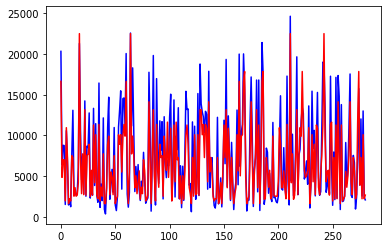

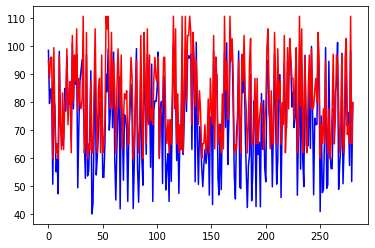

In [51]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.tree import DecisionTreeRegressor
best_dtr = DecisionTreeRegressor(criterion='mse', max_depth=15, max_features='log2',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
best_dtr.fit(X_train, Y_train)
Y_pred = best_dtr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold[:,0], 'b')
plt.plot(Y_pred[:,0], 'r')
plt.figure()
plt.plot(Y_fold[:,1], 'b')
plt.plot(Y_pred[:,1], 'r')

r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores_runtime = (absolute_percentage_error(Y_fold[:,0], Y_pred[:,0]))
mape_scores_power = (absolute_percentage_error(Y_fold[:,1], Y_pred[:,1]))

print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE:Runtime \n', mape_scores_runtime)
print('\nMAPE:Power \n', mape_scores_power)


# 7. Random Forest + Grid Search

In [52]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                            max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                            bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                            verbose=0, warm_start=False)
# defining parameter range 
param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ],
              'warm_start': ['True', 'False'],

             } 
'''
param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ],
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'max_leaf_nodes' : [None, 10, 50, 100, 200], 
              'warm_start': ['True', 'False'],
              
             }'''
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
tqdm(grid.fit(X_train, Y_train)) 

# print best parameter after tuning 
print(grid.best_params_) 
  


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=-0.015, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.749, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.715, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.384, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.738, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.745, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.176, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.783, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.723, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.183, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.794, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.707, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.143, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.768, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.729, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.198, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.773, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.710, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.219, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.779, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.720, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.210, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.777, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.723, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.375, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.786, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.763, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.289, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.810, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.775, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.332, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.815, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.753, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.327, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.840, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.749, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.186, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.832, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.767, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.147, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.807, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.749, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.156, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.815, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.755, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.256, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.833, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.745, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.027, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.866, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.731, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.465, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.848, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.748, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.352, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.846, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.745, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.256, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.871, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.753, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.342, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.837, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.772, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.298, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.851, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.741, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.270, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.856, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.768, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.273, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.845, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.762, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.145, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.839, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.725, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.007, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.865, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.719, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.297, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.787, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.715, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.258, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.892, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.736, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.257, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.901, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.745, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.308, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.866, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.728, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.324, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.878, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.739, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.302, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.880, total=   0.4s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.747, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.175, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.847, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.757, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.491, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.873, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.754, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.218, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.878, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.728, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.387, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.872, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.735, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.345, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.876, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.745, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.266, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.871, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.725, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.294, total=   0.5s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.877, total=   0.5s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.741, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.249, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.867, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.728, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.233, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.868, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.784, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.009, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.693, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.747, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.396, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.844, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.747, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.318, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.843, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.731, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.198, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.863, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.721, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.324, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.869, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.740, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.324, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.878, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.742, total=   0.6s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.240, total=   0.9s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.867, total=   0.6s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.732, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.259, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.849, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.721, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.126, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.838, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.735, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.375, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.845, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.733, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.316, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.881, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.720, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.201, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.874, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.726, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.281, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.864, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.732, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.242, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.867, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.734, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.229, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.867, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.722, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.473, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.790, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.700, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.297, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.795, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.704, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.226, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.819, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.729, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.306, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.811, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.735, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.267, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.817, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.734, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.252, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.821, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.733, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.240, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.820, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.727, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.299, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.820, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.727, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.332, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.843, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.753, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.031, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.753, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.330, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.853, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.756, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.244, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.841, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.756, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.292, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.860, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.752, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.353, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.852, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.749, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.298, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.856, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.746, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.297, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.860, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.748, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.230, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.874, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.768, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.033, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.847, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.266, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.872, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.768, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.321, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.871, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.763, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.278, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.871, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.767, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.251, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.882, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.769, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.276, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.874, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.765, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.288, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.875, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.766, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.121, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.864, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.738, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.271, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.852, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.216, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.879, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.773, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.255, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.883, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.770, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.273, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.882, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.771, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.404, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.890, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.763, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.276, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.891, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.768, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.245, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.887, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.772, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.401, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.842, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.748, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.387, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.871, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.772, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.342, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.884, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.767, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.195, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.888, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.764, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.242, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.877, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.758, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.320, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.886, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.770, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.257, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.887, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.767, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.249, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.882, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.767, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.257, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.844, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.759, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.177, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.750, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.297, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.886, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.762, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.154, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.884, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.768, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.284, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.885, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.762, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.315, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.889, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.764, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.256, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.888, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.765, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.256, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.881, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.765, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.135, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.848, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.765, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.326, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.870, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.762, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.193, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.890, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.767, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.245, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.888, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.763, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.265, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.888, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.761, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.282, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.889, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.767, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.236, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.892, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.765, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.194, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.885, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.767, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.052, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.654, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.742, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=-0.184, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.747, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.706, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.162, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.757, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.729, total=   0.2s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.235, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.706, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.729, total=   0.2s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.267, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.711, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.745, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.208, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.733, total=   0.7s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.727, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.275, total=   1.5s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.733, total=   1.3s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.728, total=   0.9s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.313, total=   1.3s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.730, total=   1.2s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.726, total=   1.0s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.250, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.772, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.778, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.183, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.806, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.764, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.316, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.808, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.759, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.301, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.804, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.756, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.262, total=   0.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.829, total=   0.7s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.756, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.307, total=   0.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.817, total=   0.7s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.759, total=   0.5s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.295, total=   1.5s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.814, total=   1.4s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.764, total=   1.1s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.298, total=   1.5s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.797, total=   1.5s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.765, total=   1.2s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.416, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.829, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.790, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.362, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.810, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.753, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.236, total=   0.5s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.814, total=   0.5s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.767, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.287, total=   0.6s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.813, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.772, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.370, total=   0.8s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.823, total=   0.8s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.782, total=   0.7s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.271, total=   1.0s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.835, total=   0.9s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.779, total=   0.6s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.291, total=   1.7s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.837, total=   1.6s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.777, total=   1.4s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.305, total=   1.7s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.842, total=   1.5s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.774, total=   1.2s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.280, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.846, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.792, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.115, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.865, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.765, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.417, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.875, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.743, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.258, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.879, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.772, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.251, total=   1.2s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.870, total=   1.1s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.758, total=   0.9s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.370, total=   1.1s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.868, total=   1.0s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.749, total=   0.8s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.270, total=   2.3s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.863, total=   2.2s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.758, total=   1.7s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.304, total=   2.0s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.856, total=   1.9s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.762, total=   1.6s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.412, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.844, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.750, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.384, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.859, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.712, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.332, total=   0.6s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.873, total=   0.6s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.757, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.332, total=   0.6s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.864, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.734, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.286, total=   1.3s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.864, total=   1.3s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.763, total=   1.1s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.273, total=   1.4s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.872, total=   1.0s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.747, total=   0.8s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.299, total=   2.2s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.873, total=   2.0s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.745, total=   1.6s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.278, total=   2.2s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.874, total=   2.0s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.759, total=   1.7s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.138, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.830, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.754, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.146, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.873, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.747, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.318, total=   0.6s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.865, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.767, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.337, total=   0.6s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.855, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.749, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.239, total=   1.1s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.857, total=   1.0s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.757, total=   0.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.227, total=   1.1s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.872, total=   1.0s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.765, total=   0.8s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.265, total=   2.2s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.867, total=   2.0s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.755, total=   1.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.293, total=   2.3s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.874, total=   2.0s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.758, total=   1.6s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.497, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.876, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.738, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.457, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.843, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.764, total=   0.1s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.243, total=   0.6s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.864, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.765, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.286, total=   0.6s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.861, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.771, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.321, total=   1.1s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.875, total=   1.0s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.754, total=   0.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.194, total=   1.1s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.871, total=   1.0s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.740, total=   0.8s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.247, total=   2.2s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.872, total=   2.0s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.753, total=   1.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.344, total=   2.3s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.869, total=   2.0s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.759, total=   1.6s


[Parallel(n_jobs=1)]: Done 504 out of 504 | elapsed:  3.1min finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
0it [00:00, ?it/s]


{'criterion': 'mse', 'max_depth': 10, 'n_estimators': 10, 'warm_start': 'False'}


# 10 fold cross validation for best Random Forest

MSE: 
 2087607.4266087266

R2: 
 0.6414910931131587

MAPE:Runtime 
 0.28189305342505844

MAPE:Power 
 0.15993270044493335


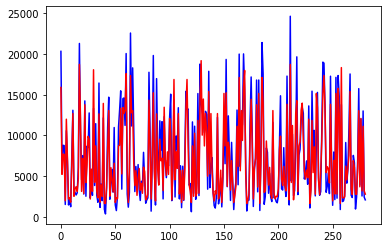

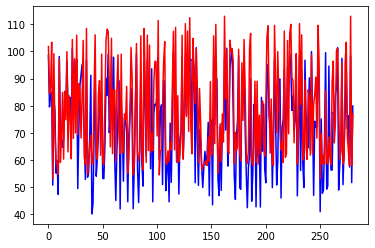

In [54]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.ensemble import RandomForestRegressor
best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start='False')
best_rf.fit(X_train, Y_train)
Y_pred = best_rf.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold[:,0], 'b')
plt.plot(Y_pred[:,0], 'r')
plt.figure()
plt.plot(Y_fold[:,1], 'b')
plt.plot(Y_pred[:,1], 'r')

r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores_runtime = (absolute_percentage_error(Y_fold[:,0], Y_pred[:,0]))
mape_scores_power = (absolute_percentage_error(Y_fold[:,1], Y_pred[:,1]))

print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE:Runtime \n', mape_scores_runtime)
print('\nMAPE:Power \n', mape_scores_power)


# 8. Extrememly Randomized Trees + Grid Search

In [55]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, criterion='mse', max_depth=None, 
                          min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                          max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, 
                          random_state=42, verbose=0, warm_start=False)


# defining parameter range 
param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ],
              'warm_start': ['True', 'False']
             }
   
'''param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ],
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'max_leaf_nodes' : [None, 10, 50, 100, 200], 
              'warm_start': ['True', 'False'],
              'bootstrap' : ['True', 'False'],
              'oob_score' :['True', 'False']
             } '''
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=-0.339, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.787, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.506, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=-0.339, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.787, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.506, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=-0.118, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.802, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.570, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=-0.118, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.802, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.570, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=-0.110, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.807, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.568, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=-0.110, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.807, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.568, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=-0.033, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.808, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.578, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=-0.033, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.808, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.578, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=-0.158, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.598, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=-0.158, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.793, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.598, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=-0.020, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.830, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.609, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=-0.020, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.830, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.609, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=-0.082, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.834, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.610, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=-0.082, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.834, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.610, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=-0.032, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.836, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.613, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=-0.032, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.836, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.613, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.003, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.844, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.595, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.003, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.844, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.595, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=-0.010, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.859, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.647, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=-0.010, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.859, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.647, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.029, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.860, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.654, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.029, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.860, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.654, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=-0.004, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.864, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.651, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=-0.004, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.864, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.651, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=-0.223, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.887, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.627, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=-0.223, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.887, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.627, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.059, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.883, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.661, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.059, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.883, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.661, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.019, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.888, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.649, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.019, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.888, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.649, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.079, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.888, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.646, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.079, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.888, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.646, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=-0.079, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.873, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.598, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=-0.079, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.873, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.598, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.081, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.887, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.621, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.081, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.887, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.621, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.043, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.892, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.633, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.043, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.892, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.633, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.017, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.894, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.629, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.017, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.894, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.629, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=-0.201, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.882, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.638, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=-0.201, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.882, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.638, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=-0.002, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.886, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.631, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=-0.002, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.886, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.631, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=-0.032, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.889, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.627, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=-0.032, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.889, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.627, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=-0.049, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.892, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.617, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=-0.049, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.892, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.617, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=-0.248, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.882, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.638, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.248, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.882, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.638, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.016, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.886, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.628, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.016, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.886, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.628, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=-0.021, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.889, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.625, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=-0.021, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.889, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.625, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=-0.043, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.892, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.616, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=-0.043, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.892, total=   0.4s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.616, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=-0.292, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.652, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=-0.292, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.788, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.652, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=-0.269, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.832, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.672, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=-0.269, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.832, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.672, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=-0.239, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.836, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.671, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=-0.239, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.836, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.671, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=-0.263, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.834, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.661, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=-0.263, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.834, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.661, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=-0.148, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.690, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=-0.148, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.827, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.690, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=-0.124, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.854, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.715, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=-0.124, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.854, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.715, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=-0.172, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.861, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.723, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=-0.172, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.861, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.723, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=-0.159, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.856, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.723, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=-0.159, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.856, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.723, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=-0.206, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.856, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=-0.206, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.856, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.754, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.057, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.867, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.752, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.057, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.867, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.752, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=-0.057, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.877, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.751, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=-0.057, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.877, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.751, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=-0.108, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.877, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.745, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=-0.108, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.877, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.745, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=-0.286, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.858, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=-0.286, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.858, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.780, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=-0.201, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.887, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.750, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=-0.201, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.887, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.750, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=-0.183, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.892, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.737, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=-0.183, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.892, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.737, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=-0.156, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.895, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.737, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=-0.156, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.895, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.737, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=-0.315, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.889, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.717, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=-0.315, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.889, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.717, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=-0.192, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.894, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.706, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=-0.192, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.894, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.706, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=-0.201, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.900, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.710, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=-0.201, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.900, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.710, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=-0.237, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.898, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.713, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=-0.237, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.898, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.713, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=-0.438, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=-0.438, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=-0.158, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.887, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.708, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=-0.158, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.887, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.708, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=-0.223, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.892, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.710, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=-0.223, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.892, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.710, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=-0.279, total=   0.5s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.895, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.705, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=-0.279, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.895, total=   0.4s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.705, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=-0.438, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.438, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.880, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.705, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=-0.159, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.887, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.708, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=-0.159, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.887, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.708, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=-0.217, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.892, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.710, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=-0.217, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.892, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.710, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=-0.273, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.895, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.705, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=-0.273, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.895, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.705, total=   0.4s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.363, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.749, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.624, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.363, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.749, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.624, total=   0.1s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.367, total=   0.4s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.786, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.673, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.367, total=   0.4s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.786, total=   0.4s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.673, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.379, total=   0.8s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.784, total=   0.7s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.681, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.379, total=   0.8s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.784, total=   0.7s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.681, total=   0.6s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.384, total=   1.5s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.784, total=   1.4s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.671, total=   1.2s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.384, total=   1.5s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.784, total=   1.6s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.671, total=   1.3s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.412, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.821, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.606, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.412, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.821, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.606, total=   0.1s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.466, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.832, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.714, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.466, total=   0.5s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.832, total=   0.5s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.714, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.419, total=   1.0s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.833, total=   0.9s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.728, total=   0.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.419, total=   1.0s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.833, total=   1.1s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.728, total=   0.9s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.416, total=   2.0s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.832, total=   1.8s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.718, total=   1.5s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.416, total=   1.8s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.832, total=   1.7s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.718, total=   1.4s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.422, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.846, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.706, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.422, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.846, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.706, total=   0.1s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.453, total=   0.5s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.869, total=   0.5s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.716, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.453, total=   0.6s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.869, total=   0.5s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.716, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.450, total=   1.1s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.866, total=   1.0s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.734, total=   0.9s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.450, total=   1.1s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.866, total=   1.0s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.734, total=   0.8s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.460, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.863, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.731, total=   1.5s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.460, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.863, total=   1.8s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.731, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.470, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.886, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.744, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.470, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.886, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.744, total=   0.1s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.547, total=   0.6s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.901, total=   0.6s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.713, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.547, total=   0.6s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.901, total=   0.6s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.713, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.532, total=   1.2s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.899, total=   1.1s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.724, total=   0.9s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.532, total=   1.2s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.899, total=   1.2s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.724, total=   0.9s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.517, total=   2.4s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.897, total=   2.4s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.737, total=   1.9s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.517, total=   2.4s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.897, total=   2.2s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.737, total=   2.0s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.715, total=   0.2s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.882, total=   0.2s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.701, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.715, total=   0.2s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.882, total=   0.2s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.701, total=   0.1s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.507, total=   0.7s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.890, total=   0.7s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.715, total=   0.6s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.507, total=   0.8s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.890, total=   0.7s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.715, total=   0.6s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.482, total=   1.4s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.889, total=   1.3s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.716, total=   1.1s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.482, total=   1.4s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.889, total=   1.3s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.716, total=   1.1s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.486, total=   2.8s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.889, total=   2.6s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.720, total=   2.2s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.486, total=   2.9s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.889, total=   2.5s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.720, total=   2.2s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.489, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.874, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.749, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.489, total=   0.2s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.874, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.749, total=   0.1s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.447, total=   0.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.888, total=   0.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.723, total=   0.6s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.447, total=   0.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.888, total=   0.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.723, total=   0.6s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.406, total=   1.5s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.886, total=   1.3s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.717, total=   1.1s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.406, total=   1.5s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.886, total=   1.3s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.717, total=   1.2s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.443, total=   2.9s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.886, total=   2.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.713, total=   2.2s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.443, total=   2.9s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.886, total=   2.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.713, total=   2.5s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.481, total=   0.2s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.874, total=   0.2s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.749, total=   0.2s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.481, total=   0.3s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.874, total=   0.3s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.749, total=   0.2s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.451, total=   1.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.887, total=   1.3s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.723, total=   1.2s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.451, total=   1.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.887, total=   1.3s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.723, total=   1.2s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.415, total=   2.9s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.885, total=   2.7s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.717, total=   2.4s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.415, total=   2.9s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.885, total=   2.5s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.717, total=   2.2s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.447, total=   5.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.886, total=   5.0s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.712, total=   4.3s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.447, total=   5.7s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.886, total=   5.5s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.712, total=   4.9s


[Parallel(n_jobs=1)]: Done 504 out of 504 | elapsed:  4.1min finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'mae', 'max_depth': 10, 'n_estimators': 10, 'warm_start': 'True'}
ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=10,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start='True')


# 10 fold cross validation for best Extra Trees Regressor 

MSE: 
 1599064.2570395856

R2: 
 0.7408229803523756

MAPE:Runtime 
 0.2922799987618577

MAPE:Power 
 0.14598193164608295


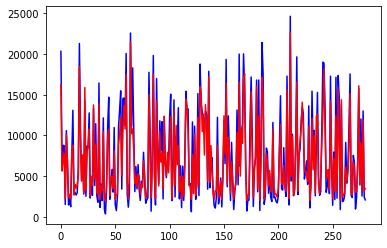

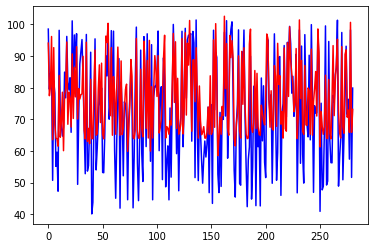

In [56]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.ensemble import ExtraTreesRegressor
best_etr = ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=10,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start='True')
best_etr.fit(X_train, Y_train)
Y_pred = best_etr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold[:,0], 'b')
plt.plot(Y_pred[:,0], 'r')
plt.figure()
plt.plot(Y_fold[:,1], 'b')
plt.plot(Y_pred[:,1], 'r')

r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores_runtime = (absolute_percentage_error(Y_fold[:,0], Y_pred[:,0]))
mape_scores_power = (absolute_percentage_error(Y_fold[:,1], Y_pred[:,1]))

print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE:Runtime \n', mape_scores_runtime)
print('\nMAPE:Power \n', mape_scores_power)
